# Предсказание температуры сплава

## Описание проекта

Чтобы оптимизировать производственные расходы, металлургический комбинат решил уменьшить потребление электроэнергии на этапе обработки стали. Для этого комбинату нужно контролировать температуру сплава. Ваша задача - построить модель, которая будет её предсказывать. Заказчик хочет использовать разработанную модель для имитации технологического процесса. 

### Описание процесса обработки

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены на крышке ковша.

Сначала происходит десульфурация - из стали выводят серу и корректируют её химический состав добавлением примесей. Затем сталь легируют - добавляют в неё куски сплава из бункера для сыпучих материалов или порошковую проволоку через специальный трайб-аппарат.

Прежде чем в первый раз ввести легирующие добавки, специалисты производят химический анализ стали и измеряют её температуру. Потом температуру на несколько минут повышают, уже после этого добавляют легирующие материалы и продувают сталь инертным газом, чтобы перемешать, а затем снова проводят измерения. Такой цикл повторяется до тех пор, пока не будут достигнуты нужный химический состав стали и оптимальная температура плавки.

Дальше расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. slab, «плита»).

### Описание данных

Данные хранятся в Sqlite  - СУБД, в которой база данных представлена одним файлом. Она состоит из нескольких таблиц:

- steel.data_arc - данные об электродах;
- steel.data_bulk - данные об объёме сыпучих материалов;
- steel.data_bulk_time - данные о времени подачи сыпучих материалов;
- steel.data_gas - данные о продувке сплава газом;
- steel.data_temp - данные об измерениях температуры;
- steel.data_wire - данные об объёме проволочных материалов;
- steel.data_wire_time - данные о времени подачи проволочных материалов.

Таблица steel.data_arc

- key - номер партии;
- BeginHeat - время начала нагрева;
- EndHeat - время окончания нагрева;
- ActivePower - значение активной мощности;
- ReactivePower - значение реактивной мощности.

Таблица steel.data_bulk

- key - номер партии;
- Bulk1 … Bulk15 - объём подаваемого материала.

Таблица steel.data_bulk_time

- key - номер партии;
- Bulk1 … Bulk15 - время подачи материала.

Таблица steel.data_gas

- key - номер партии;
- gas - объём подаваемого газа.

Таблица steel.data_temp

- key - номер партии;
- MesaureTime - время замера;
- Temperature - значение температуры.

Таблица steel.data_wire

- key - номер партии;
- Wire1 … Wire9 - объём подаваемых проволочных материалов.

Таблица steel.data_wire_time

- key - номер партии;
- Wire1 … Wire9 - время подачи проволочных материалов.

Во всех файлах столбец key содержит номер партии. В таблицах может быть несколько строк с одинаковым значением key: они соответствуют разным итерациям обработки.

## Шаг 1. Загрузка данных

In [112]:
# Установим недостающие библиотеки

!pip install sqlalchemy
!pip install requests
!pip install seaborn
!pip install shap
!pip install phik
!pip install statsmodels
!pip install scikeras


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [113]:
# Импортируем нужные библиотеки

import os
import warnings
from typing import Optional, Tuple, Literal

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sqlalchemy import create_engine, inspect, Engine

import requests

from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    GridSearchCV
)
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import (
    mean_absolute_error,
    r2_score
)
from sklearn.model_selection import KFold

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor


import shap
import phik
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("float32")

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

from scikeras.wrappers import KerasRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

tf.config.optimizer.set_jit(False)

In [114]:
# Игнорируем предупреждения

warnings.filterwarnings("ignore", category=FutureWarning)

In [115]:
# Определим константы

RANDOM_STATE = 61025
TEST_SIZE = 0.25

In [116]:
# Загрузим базу данных

url = "https://huggingface.co/datasets/onejetpilot/alloy_temp/resolve/main/alloy_temp.db"
filename = "alloy_temp.db"

if os.path.exists(filename):
    print(f"Файл '{filename}' уже существует")
else:
    response = requests.get(url)
    response.raise_for_status()

    with open(filename, "wb") as f:
        f.write(response.content)

    print("Файл скачан", filename)

Файл скачан alloy_temp.db


In [117]:
# Откроем базу данных

engine = create_engine(f'sqlite:///{filename}', echo=False)

In [118]:
# Создаём инспектор

inspector = inspect(engine)

In [119]:
# Получаем список таблиц

tables = inspector.get_table_names()
print(f"Список таблиц в {filename}:")
for t in tables:
    print(t)

Список таблиц в alloy_temp.db:
contract
data_arc
data_bulk
data_bulk_time
data_gas
data_temp
data_wire
data_wire_time
internet
personal
phone


Таблиц получилось больше чем дано в условии задачи, загрузим только те которые нужны. Остальные таблицы, насколько я понял, для другого проекта.

In [120]:
def load_table(engine: Engine,
               table_name: str
) -> pd.DataFrame:
    """
    Загружает таблицу из SQLite базы данных в pandas.DataFrame.

    Параметры
    ----------
    engine : sqlalchemy.engine.Engine
        Активное подключение к базе данных, созданное через `create_engine`.
    table_name : str
        Имя таблицы, которую нужно загрузить.

    Возвращает
    ----------
    pd.DataFrame
        Таблица, загруженная в формате pandas DataFrame.
    """
    query = f"SELECT * FROM {table_name}"
    return pd.read_sql(query, engine)

In [121]:
# Загрузим таблицы из базы данных в датасеты

data_arc = load_table(engine, "data_arc")
data_bulk = load_table(engine, "data_bulk")
data_bulk_time = load_table(engine, "data_bulk_time")
data_gas = load_table(engine, "data_gas")
data_temp = load_table(engine, "data_temp")
data_wire = load_table(engine, "data_wire")
data_wire_time = load_table(engine, "data_wire_time")

### Вывод

Загрузили данные таблицы базы данных в датасете. Назначили RANDOM_STATE=61025 по дате начала работы.

## Шаг 2. Исследовательский анализ и предобработка данных

### Анализ исходных данных

In [ ]:
def overview_data(
        data: pd.DataFrame
) -> None:
    """
    Выводит информацию о DataFrame - типы данных,
    статистику, количество пропусков и дубликатов

    Параметры
    ----------
    data : pandas.DataFrame
        Таблица данных, для которой требуется провести обзор

    Возвращает
    ----------
    None
        Функция выводит информацию
    """

    d = '-' * 50

    print(d)
    print('Инфо')
    print(d)
    data.info()
    print('\n')

    print(d)
    print('Статистика')
    print(d)
    print(data.describe())
    print('\n')

    print(d)
    print('Пропуски')
    print(d)
    print(data.isna().sum())
    print('\n')

    print(d)
    print('Дубликаты')
    print(d)
    print(data.duplicated().sum())
    print('\n')

    print(d)
    print('Нулевые значения')
    print(d)
    print((data == 0).sum())
    print('\n')

In [123]:
# Посмотрим датасет data_arc

overview_data(data_arc)

--------------------------------------------------
Инфо
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


--------------------------------------------------
Статистика
--------------------------------------------------
                key  Активная мощность  Реактивная мощность
count  14876.000000       14876.000000         14876.000000
mean    1615.220422           0.662752             0.438986
std      934.571502           0.258885             5.873485
min      

In [124]:
data_arc.head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691


Проблемы data_arc:
- Начало нагрева дугой, Конец нагрева дугой - не верный тип данных, изменим на datetime
- Реактивная мощность - не может быть отрицательной, удалим или постараемся исправить


In [125]:
# Посмотрим датасет data_bulk

overview_data(data_bulk)

--------------------------------------------------
Инфо
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     object 
 6   Bulk 6   576 non-null    object 
 7   Bulk 7   25 non-null     object 
 8   Bulk 8   1 non-null      object 
 9   Bulk 9   19 non-null     object 
 10  Bulk 10  176 non-null    object 
 11  Bulk 11  177 non-null    object 
 12  Bulk 12  2450 non-null   object 
 13  Bulk 13  18 non-null     object 
 14  Bulk 14  2806 non-null   object 
 15  Bulk 15  2248 non-null   object 
dtypes: float64(4), int64(1), object(11)
memory usage: 391.2+ KB


-----------------------------------

In [126]:
data_bulk.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,None,None,None,None,None,None,None,206.0,None,150.0,154.0
1,2,NaN,NaN,NaN,73.0,None,None,None,None,None,None,None,206.0,None,149.0,154.0
2,3,NaN,NaN,NaN,34.0,None,None,None,None,None,None,None,205.0,None,152.0,153.0
3,4,NaN,NaN,NaN,81.0,None,None,None,None,None,None,None,207.0,None,153.0,154.0
4,5,NaN,NaN,NaN,78.0,None,None,None,None,None,None,None,203.0,None,151.0,152.0


Проблемы data_bulk:
- Тип данных объема подаваемых материалов можно изменить с float на int
- Много пропусков, однако по условию задачи - если пропуск - материал не подавали. Можем заменить пропуски на 0.

In [127]:
# Посмотрим датасет data_bulk_time

overview_data(data_bulk_time)

--------------------------------------------------
Инфо
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


--------------------------------------------------
Статистика
---

In [128]:
data_bulk_time.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,None,None,None,2019-05-03 11:28:48,None,None,None,None,None,None,None,2019-05-03 11:24:31,None,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,None,None,None,2019-05-03 11:36:50,None,None,None,None,None,None,None,2019-05-03 11:53:30,None,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,None,None,None,2019-05-03 12:32:39,None,None,None,None,None,None,None,2019-05-03 12:27:13,None,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,None,None,None,2019-05-03 12:43:22,None,None,None,None,None,None,None,2019-05-03 12:58:00,None,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,None,None,None,2019-05-03 13:30:47,None,None,None,None,None,None,None,2019-05-03 13:30:47,None,2019-05-03 13:34:12,2019-05-03 13:30:47


Проблемы data_bulk_time:
- Тип данных по времени подачи материалов нужно заменить на datetime
- Много пропусков, однако по условию задачи - если пропуск - материал не подавали. Можем заменить пропуски на 0.

In [129]:
# Посмотрим датасет data_gas

overview_data(data_gas)

--------------------------------------------------
Инфо
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


--------------------------------------------------
Статистика
--------------------------------------------------
               key        Газ 1
count  3239.000000  3239.000000
mean   1621.861377    11.002062
std     935.386334     6.220327
min       1.000000     0.008399
25%     812.500000     7.043089
50%    1622.000000     9.836267
75%    2431.500000    13.769915
max    3241.000000    77.995040


--------------------------------------------------
Пропуски
--------------------------------------------------
key      0
Газ 1    0
dtype: int64


-----------------------------------

In [130]:
data_gas.head()

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


Проблемы data_gas:
- С первого взгляда каких-то проблем с данными нет

In [131]:
# Посмотрим датасет data_temp

overview_data(data_temp)

--------------------------------------------------
Инфо
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   key           18092 non-null  int64 
 1   Время замера  18092 non-null  object
 2   Температура   14665 non-null  object
dtypes: int64(1), object(2)
memory usage: 424.2+ KB


--------------------------------------------------
Статистика
--------------------------------------------------
                key
count  18092.000000
mean    1616.460977
std      934.641385
min        1.000000
25%      807.750000
50%     1618.000000
75%     2429.000000
max     3241.000000


--------------------------------------------------
Пропуски
--------------------------------------------------
key                0
Время замера       0
Температура     3427
dtype: int64


-------------------------------------

In [132]:
data_temp.head()

,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0


Проблемы data_temp:
- Время замера - нужно поменять тип данных на datetime
- Температура - меняем тип данных на int
- Есть много пропусков по температуре, необходимо заполнить
- Есть аномальные значения с температурой менее 1500 гардусов

In [133]:
# Посмотрим датасет data_wire

overview_data(data_wire)

--------------------------------------------------
Инфо
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   object 
 3   Wire 3  63 non-null     object 
 4   Wire 4  14 non-null     object 
 5   Wire 5  1 non-null      object 
 6   Wire 6  73 non-null     object 
 7   Wire 7  11 non-null     object 
 8   Wire 8  19 non-null     object 
 9   Wire 9  29 non-null     object 
dtypes: float64(1), int64(1), object(8)
memory usage: 240.8+ KB


--------------------------------------------------
Статистика
--------------------------------------------------
               key       Wire 1
count  3081.000000  3055.000000
mean   1623.426485   100.895853
std     932.996726    42.012518
min       1.000000     1.918800
25%

In [134]:
data_wire.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,None,None,None,None,None,None,None,None
1,2,96.052315,None,None,None,None,None,None,None,None
2,3,91.160157,None,None,None,None,None,None,None,None
3,4,89.063515,None,None,None,None,None,None,None,None
4,5,89.238236,9.11456,None,None,None,None,None,None,None


Проблемы data_wire:
- Необходимо обработать большое количество пропусков

In [135]:
# Посмотрим датасет data_wire_time

overview_data(data_wire_time)

--------------------------------------------------
Инфо
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


--------------------------------------------------
Статистика
--------------------------------------------------
               key
count  3081.000000
mean   1623.426485
std     932.996726
min       1.000000
25%     823.000000
50%    1619.000000
75%    2434.000000
max    3241.000000


--------------

In [136]:
data_wire_time.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,None,None,None,None,None,None,None,None
1,2,2019-05-03 11:36:50,None,None,None,None,None,None,None,None
2,3,2019-05-03 12:11:46,None,None,None,None,None,None,None,None
3,4,2019-05-03 12:43:22,None,None,None,None,None,None,None,None
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,None,None,None,None,None,None,None


Проблемы data_wire_time:
- Необходимо обработать большое количество пропусков
- Изменить тип данных на datetime

- Все таблицы содержат данные
- Количество таблиц соответствует задаче

#### data_arc - данные об электродах

- Проведем исследовательский анализ данных: проверим наличие пропусков и аномалий, изучим распределение признаков.
- Нам нужно либо удалить всю партию с аномальным значением, либо заменить аномальное значение, основываясь на нормальных наблюдениях.
- Попробуем сгенерировать новые признаки, которые могут пригодиться при обучении: длительность нагрева, общую мощность, соотношение активной мощности к реактивной, количество запуска нагрева электродами и другие.
- При агрегировании наблюдений по ключу учтем порядок арифметических действий: сначала сгенерируйте новые признаки, затем уже агрегируйте наблюдения.

In [137]:
def num_diag(
    data: pd.DataFrame,
    x: str,
    xlabel: str,
    ylabel: str,
    hue: Optional[str] = None
) -> None:
    """
    Визуализирует распределение числового признака с помощью гистограммы и boxplot

    Параметры
    ----------
    data : pandas.DataFrame
        Таблица данных, содержащая признак

    x : str
        Название числового признака, по которому строятся графики.

    xlabel : str
        Подпись оси X для графиков

    ylabel : str
        Подпись оси Y для графиков.=

    hue : str, optional
        Название категориального признака для разделения данных по цветам на гистограмме

    Возвращает
    ----------
    None
        Функция строит графики
    """


    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    sns.histplot(
        data=data,
        x=x,
        hue=hue,
        ax=axes[0],
        stat='density',
        bins=20,
        common_norm=False)
    axes[0].set_title(f'Гистограмма по {xlabel}')
    axes[0].set_xlabel(xlabel)
    axes[0].set_ylabel(ylabel)

    sns.boxplot(
        data=data,
        x=x,
        ax=axes[1])
    axes[1].set_title(f'Гистограмма размаха по {xlabel}')
    axes[1].set_xlabel(xlabel)
    axes[1].set_ylabel(ylabel)

    plt.tight_layout()
    plt.show()

In [138]:
def cat_diag(
    data: pd.DataFrame,
    x: str,
    xlabel: str,
    hue: Optional[str] = None,
    threshold: float = 0.015
) -> None:
    """
    Строит диаграммы распределения для категориального признака:
    countplot с группировкой и круговую диаграмму

    Малые категории по частоте объединяются в категорию "Другие"

    Параметры
    ----------
    data : pandas.DataFrame
        Таблица с данными, содержащая категориальный признак

    x : str
        Название категориального признака, по которому строятся графики

    xlabel : str
        Подпись оси X на countplot

    hue : str, optional
        Название категориального признака для группировки по цветам на countplot

    threshold : float, optional
        Порог частоты (от 0 до 1), ниже которого категории объединяются в "Другие"
        По умолчанию 0.015 (1.5%)

    Возвращает
    ----------
    None
        Функция строит графики
    """


    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    value_counts = data[x].value_counts(normalize=True)
    small_categories = value_counts[value_counts<threshold].index
    data_modified = data.copy()
    data_modified[x] = data_modified[x].apply(lambda val: 'Другие' if val in small_categories else val)

    sns.countplot(
        data=data_modified,
        x=x,
        hue=hue,
        ax=axes[0],
        order=data_modified[x].value_counts().index)
    axes[0].set_title(f'Диаграмма по {xlabel}')
    axes[0].set_ylabel('Количество')
    axes[0].set_xlabel(xlabel)
    axes[0].tick_params(axis='x', rotation=45)

    pie_data = data_modified[x].value_counts(normalize=True)

    pie_data.plot(
        kind='pie',
        labels=pie_data.index,
        legend=False,
        autopct='%1.0f%%',
        ax=axes[1],
        startangle=90,
        counterclock=False)
    axes[1].set_title('Распределение долей')
    axes[1].set_ylabel('')

    plt.tight_layout()
    plt.show()

In [139]:
def date_diag(
    data: pd.DataFrame,
    x: str,
    hue: Optional[str] = None,
    figsize: Tuple[int, int] = (16, 6)
) -> None:
    """
    Строит временную диаграмму (countplot) по дате.

    Преобразует datetime-признак в даты без времени и отображает
    количество записей по каждой дате. Если нужно, можно применить
    цветовую группировку по hue

    Параметры
    ----------
    data : pandas.DataFrame
        Таблица данных, содержащая временной признак

    x : str
        Название столбца с типом datetime

    hue : str, optional
        Название категориального признака для группировки по цветам

    figsize : tuple, optional
        Размер графика в формате (ширина, высота), по умолчанию (16, 6)

    Возвращает
    ----------
    None
        Функция строит график
    """


    data_modified = data.copy()
    data_modified['date'] = data_modified[x].dt.date
    plt.figure(figsize=figsize)
    ax = sns.countplot(
        data=data_modified,
        x='date',
        hue=hue,
        order=sorted(data_modified['date'].unique()))

    plt.title(f'Диаграмма по {x}')
    plt.xlabel('Дата')
    plt.ylabel('Количество записей')
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

In [140]:
def all_diag(
    data: pd.DataFrame,
    column_type: Literal['numeric', 'categorical', 'date', 'datetime'] = 'numeric',
    hue: Optional[str] = None
) -> None:
    """
    Автоматически визуализирует признаки заданного типа: числовые, категориальные или временные.

    В зависимости от типа признаков вызывает соответствующие функции визуализации
    (num_diag, cat_diag, date_diag) для каждого подходящего столбца в DataFrame.

    Параметры
    ----------
    data : pandas.DataFrame
        Таблица данных для анализа

    column_type : str, optional
        Тип признаков для визуализации. Возможные значения:
        - 'numeric' - числовые признаки
        - 'categorical' - категориальные признаки
        - 'date' или 'datetime' - временные признаки

    hue : str, optional
        Название столбца для цветовой группировки, если нужно

    Возвращает
    ----------
    None
         Функция строит график
    """


    if column_type == 'numeric':
        columns = data.select_dtypes(include='number').columns
    elif column_type == 'categorical':
        columns = data.select_dtypes(include=['object', 'category']).columns
    elif column_type in ('date', 'datetime'):
        columns = data.select_dtypes(include=['datetime64[ns]', 'datetime64']).columns

    for col in columns:
        if column_type == 'numeric':
            print(f'Визуализация числового признака: {col}')
            num_diag(data, x=col, xlabel=col, ylabel='Плотность распределения', hue=hue)
        elif column_type == 'categorical':
            print(f'Визуализация категориального признака {col}')
            cat_diag(data, x=col, xlabel=col, hue=hue)
        elif column_type == 'date':
            print(f'Визуализация верменного признака: {col}')
            date_diag(data, x=col, hue=hue)

In [141]:
# Создадим копию

data_arc_v2 = data_arc.copy()

In [142]:
# Переименуем колонки

data_arc_v2 = data_arc_v2.rename(columns={
    "Начало нагрева дугой": "BeginHeat",
    "Конец нагрева дугой": "EndHeat",
    "Активная мощность": "ActivePower",
    "Реактивная мощность": "ReactivePower"
})

In [143]:
# Сменим типы данных на datetime

data_arc_v2["BeginHeat"] = pd.to_datetime(data_arc_v2["BeginHeat"], errors="coerce")
data_arc_v2["EndHeat"] = pd.to_datetime(data_arc_v2["EndHeat"], errors="coerce")

Визуализация числового признака: ActivePower


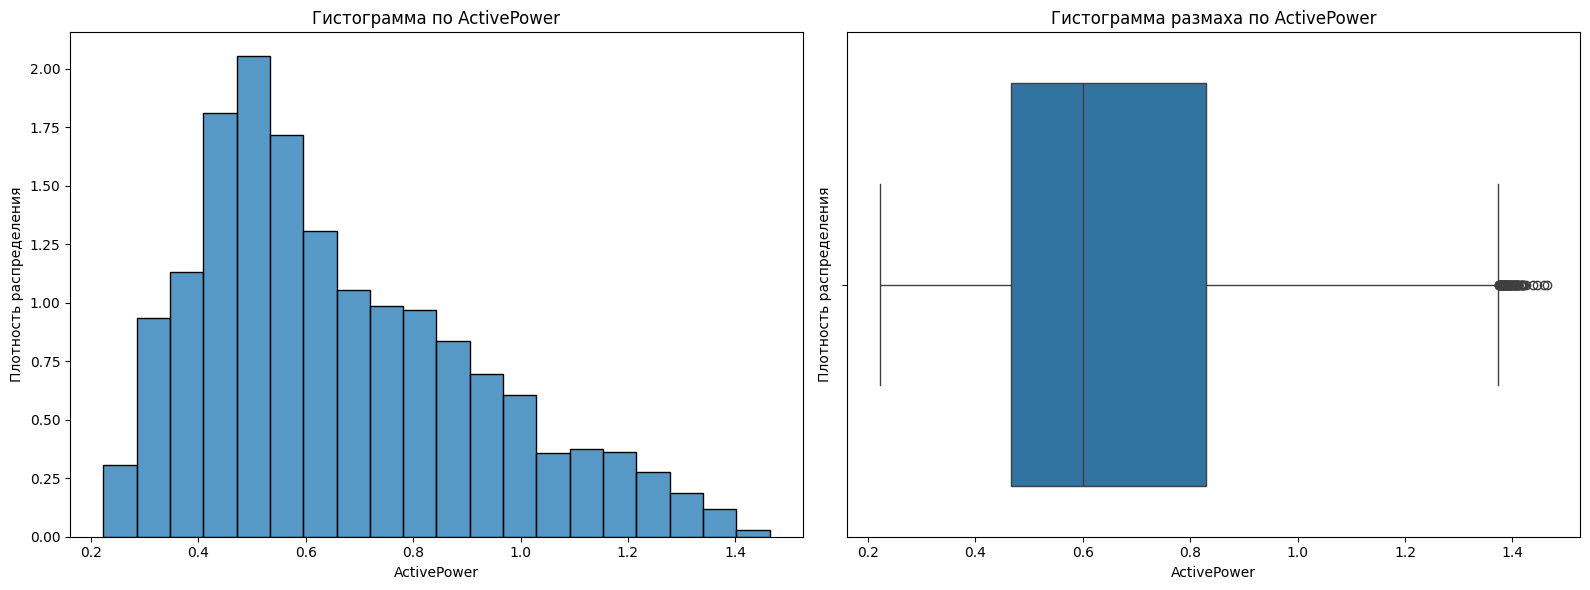

Визуализация числового признака: ReactivePower


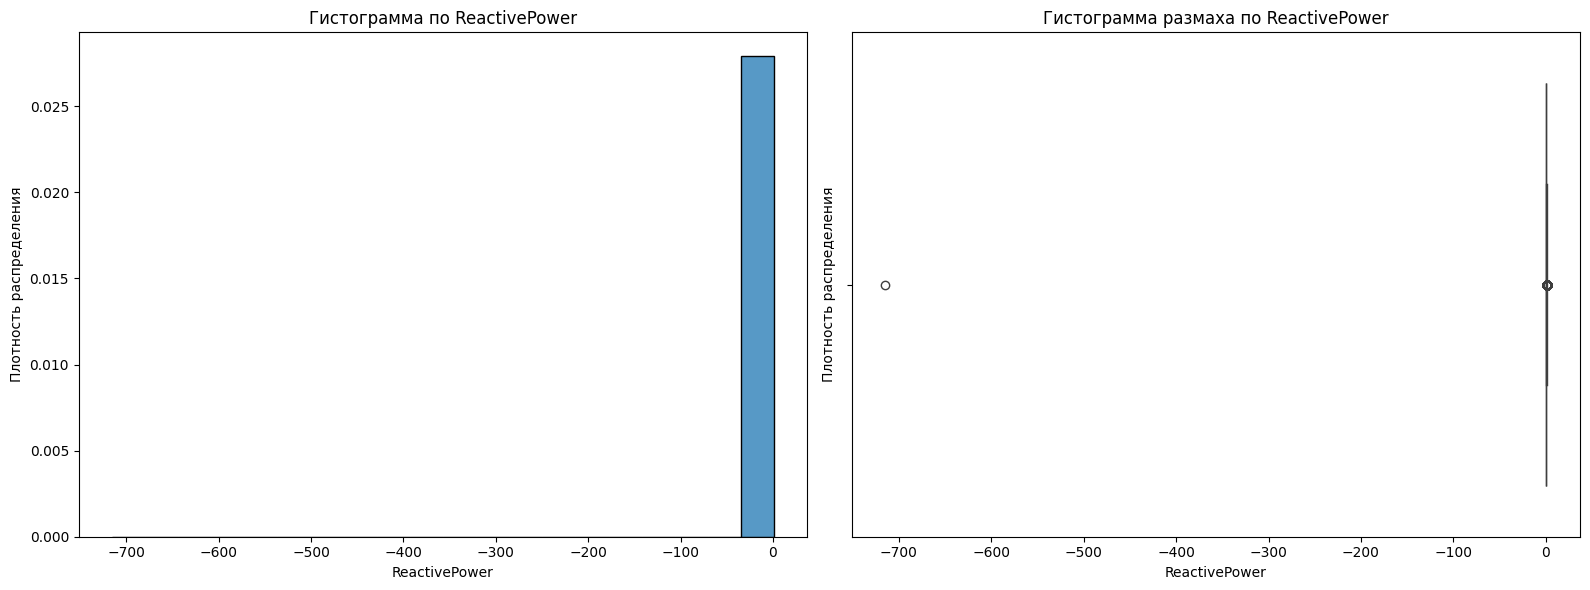

In [144]:
# Визуализируем числовые признаки data_arc

all_diag(data_arc_v2.drop(columns=["key"]), column_type='numeric')

Видим отрицательные значения в ReactivePower, это явно ошибка.

In [145]:
# Посмотрим на аномалии в ReactivePower

data_arc_v2[data_arc_v2["ReactivePower"]<=0].head()

,key,BeginHeat,EndHeat,ActivePower,ReactivePower
9780,2116,2019-07-28 02:22:08,2019-07-28 02:23:57,0.705344,-715.479924


In [146]:
# Посмотрим на эксперименты с тем же ключом

data_arc_v2[data_arc_v2["key"]==2116].head()

,key,BeginHeat,EndHeat,ActivePower,ReactivePower
9778,2116,2019-07-28 02:07:12,2019-07-28 02:09:14,0.787549,0.693881
9779,2116,2019-07-28 02:13:10,2019-07-28 02:15:25,0.580263,0.411498
9780,2116,2019-07-28 02:22:08,2019-07-28 02:23:57,0.705344,-715.479924
9781,2116,2019-07-28 02:29:11,2019-07-28 02:30:18,0.563641,0.408513


- BeginHeat - время начала нагрева и EndHeat - время окончания нагрева - тут сложно что либо сказать т.к. тут просто время начала и конца нагрева. Сделаем колонку в секундах которая покажет нам продолжительность нагрева. После создания этой колонки оригинальные колонки удалим.
- ActivePower - значение активной мощности - есть выбросы, однако думаю они вполне реальны и трогать их не будем. Добавим колонку с общей мощностью.
- ReactivePower - значение реактивной мощности - есть одно отрицательное значение, что невозможно. Скорее всего это ошибка. Попробуем добавить колонку с отношением ActivePower\ReactivePower и получить среднее значение этого отношения по конкретной партии. Потом умножим ActivePower на это отношение и заменим ошибочное значение.

Также добавим колонку с количеством запусков нагрева.


In [147]:
# Добавим новые признаки и удалим EndHeat и BeginHeat

data_arc_v2["HeatDuration"] = (data_arc_v2["EndHeat"] - data_arc_v2["BeginHeat"]).dt.total_seconds()
data_arc_v2["FullPower"] = data_arc_v2["ActivePower"] + data_arc_v2["ReactivePower"]
data_arc_v2["PowerRatio"] = data_arc_v2["ActivePower"] / data_arc_v2["ReactivePower"]
data_arc_v2["HeatCount"] = data_arc_v2.groupby("key")["key"].transform("count")

data_arc_v2 = data_arc_v2.drop(columns=["EndHeat", "BeginHeat"])

In [148]:
# Заменим ошибочное значение

mask_bad = data_arc_v2["ReactivePower"] < 0
mean_ratio_by_key = (data_arc_v2.loc[~mask_bad].groupby("key")["PowerRatio"].mean())
data_arc_v2.loc[mask_bad, "ReactivePower"] = (data_arc_v2.loc[mask_bad, "ActivePower"] / data_arc_v2.loc[mask_bad, "key"].map(mean_ratio_by_key))

In [149]:
# Заново пересчитаем новые признаки FullPower и PowerRatio, т.к. они считались с ошибкой

data_arc_v2["FullPower"] = data_arc_v2["ActivePower"] + data_arc_v2["ReactivePower"]
data_arc_v2["PowerRatio"] = data_arc_v2["ActivePower"] / data_arc_v2["ReactivePower"]

In [150]:
# Посмотрим произведенные замены и новые признаки

data_arc_v2[data_arc_v2["key"]==2116].head()

,key,ActivePower,ReactivePower,HeatDuration,FullPower,PowerRatio,HeatCount
9778,2116,0.787549,0.693881,122.0,1.481430,1.134991,4
9779,2116,0.580263,0.411498,135.0,0.991761,1.410123,4
9780,2116,0.705344,0.539137,109.0,1.244481,1.308284,4
9781,2116,0.563641,0.408513,67.0,0.972154,1.379738,4


Визуализация числового признака: ActivePower


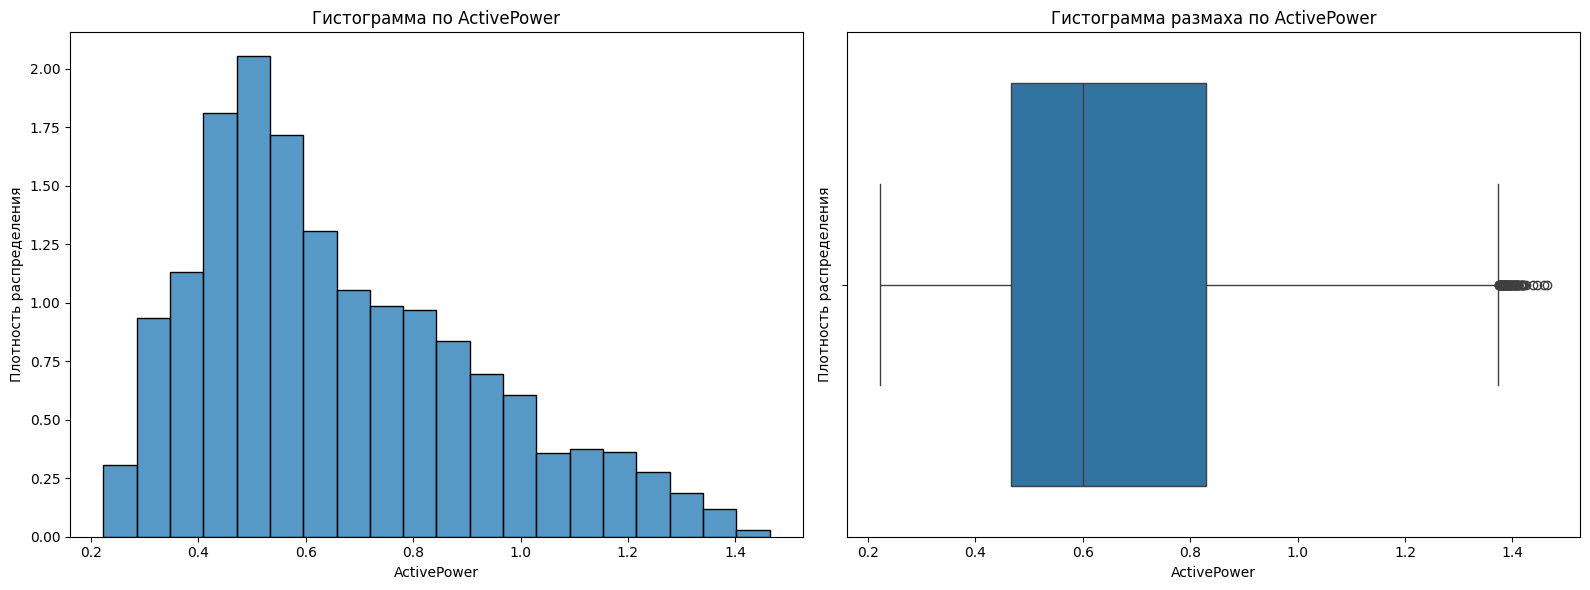

Визуализация числового признака: ReactivePower


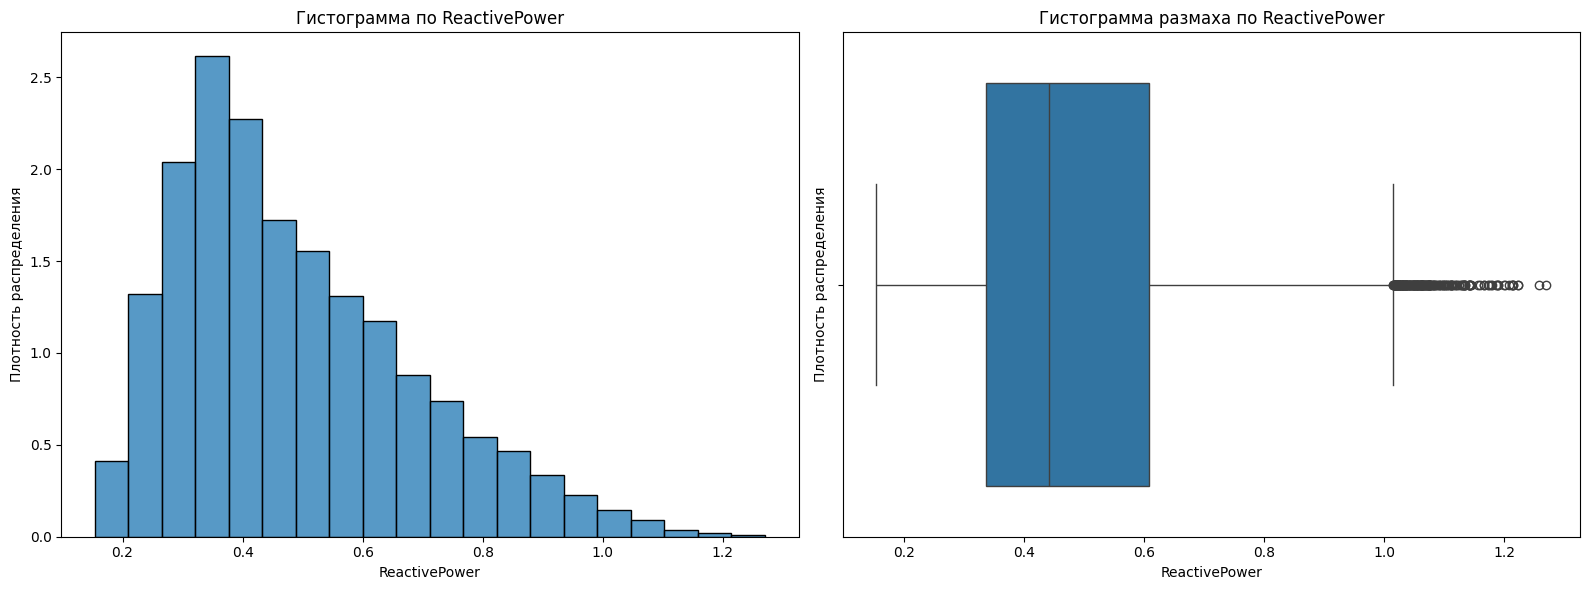

Визуализация числового признака: HeatDuration


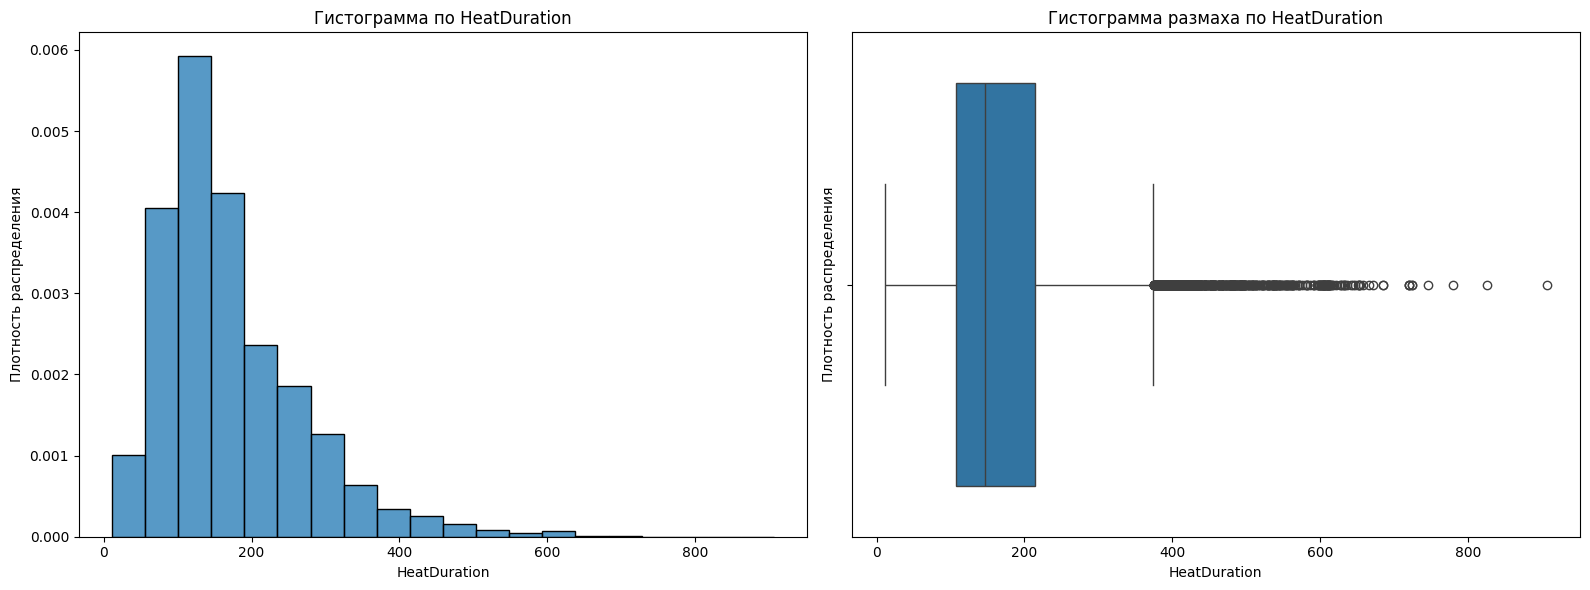

Визуализация числового признака: FullPower


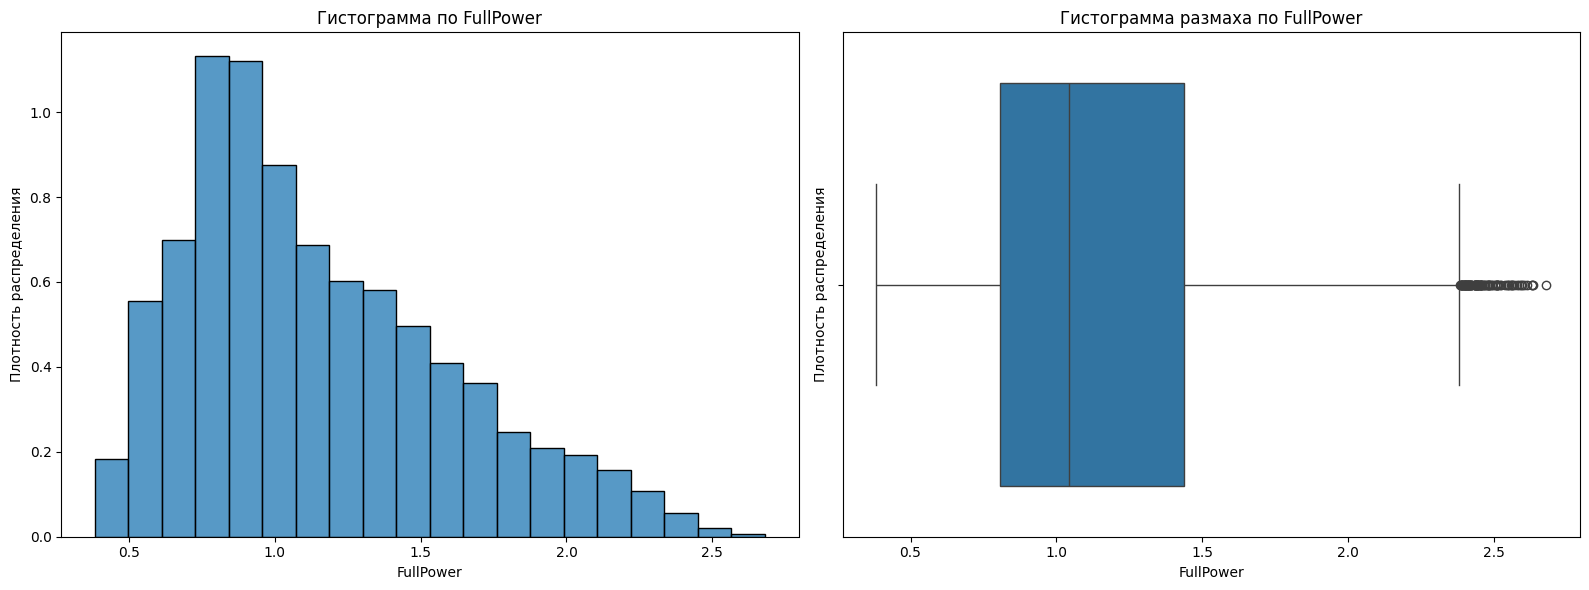

Визуализация числового признака: PowerRatio


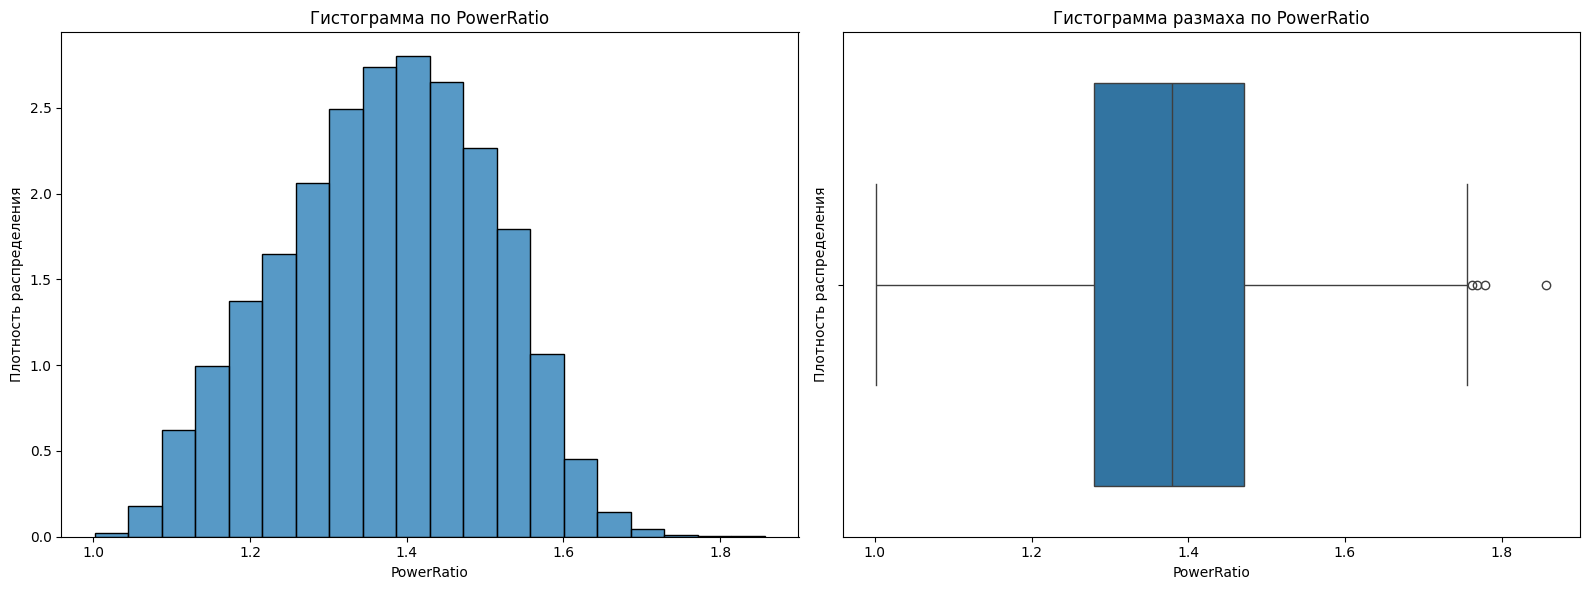

Визуализация числового признака: HeatCount


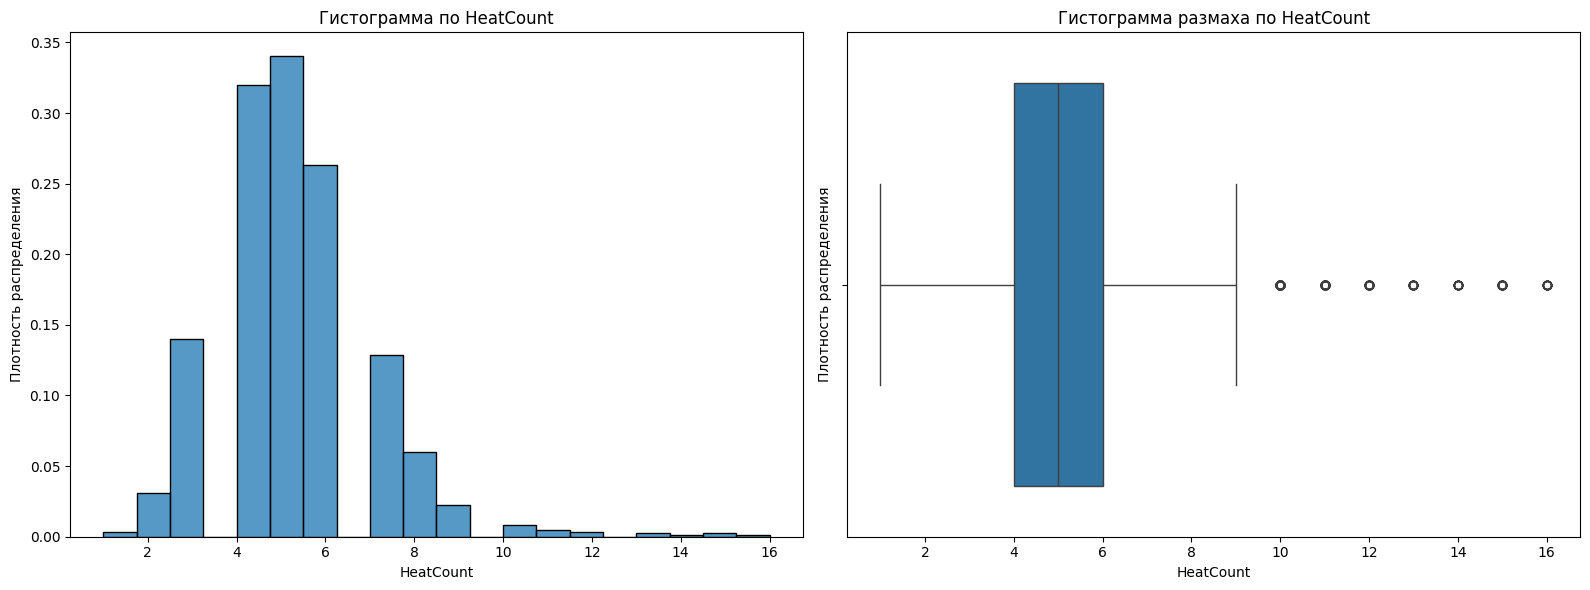

In [151]:
# Визуализируем получившийся датасет

all_diag(data_arc_v2.drop(columns=["key"]))

Проанализируем получившиеся графики:

- ActivePower - распределение плавно убывает вправо, пик около 0.4-0.6, далее значения постепенно снижаются. Есть редкие выбросы свыше 1.3-1.4. Признак оставляем.
- ReactivePower - схожее распределение, но чуть сильнее скошено вправо. Основная масса значений - 0.3-0.6, выбросы до 1.2-1.3. Признак оставляем.
- HeatDuration - значения имеют выраженный правый хвост. Основная масса - 100–250, но отдельные значения достигают 800–900, что явно выбросы (долгие плавки). Признак оставляем, так как отражает важный технологический процесс.
- FullPower - распределение аналогично ActivePower, пик около 0.8-1.0, хвост до 2.5+. Признак оставляем.
- PowerRatio - распределение почти нормальное, с центром около 1.4. Признак оставляем.
- HeatCount - дискретное распределение, пик около 4-6, редкие значения до 15-16. Признак оставляем.

#### data_bulk - данные об объёме сыпучих материалов

- Проведем исследовательский анализ данных: проверим наличие пропусков и аномалий, изучим распределение признаков.
- Обработаем пропуски. Пропуск означает, что материал не добавляли в партию.

In [152]:
# Создадим копию

data_bulk_v2 = data_bulk.copy()

In [153]:
# Приведем все столбцы к типу числовому типу

data_bulk_v2 = data_bulk_v2.apply(pd.to_numeric, errors='coerce')

In [154]:
# Добавим колонку с общим объемом сыпучих материалов и сколько раз сыпучие материалы подавались

bulk_cols = [f"Bulk {i}" for i in range(1, 16)]
data_bulk_v2["FullBulk"] = data_bulk_v2[bulk_cols].sum(axis=1)
data_bulk_v2["BulkCount"] = data_bulk_v2[bulk_cols].notna().sum(axis=1)

In [155]:
# Оставляем столбцы, где доля пропусков < 90%

cols_keep = data_bulk_v2.columns[data_bulk_v2.notna().mean() >= 0.10]
cols_keep = cols_keep.difference(["key"])

Визуализация числового признака: Bulk 12


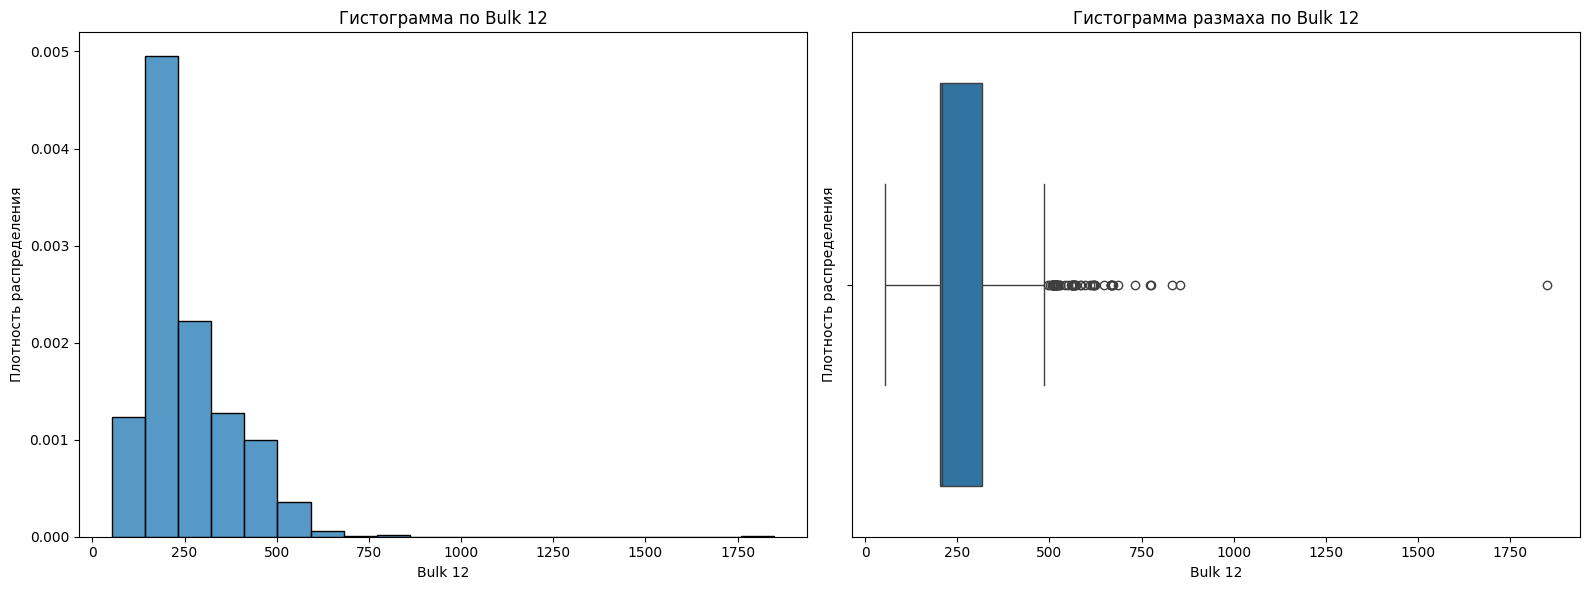

Визуализация числового признака: Bulk 14


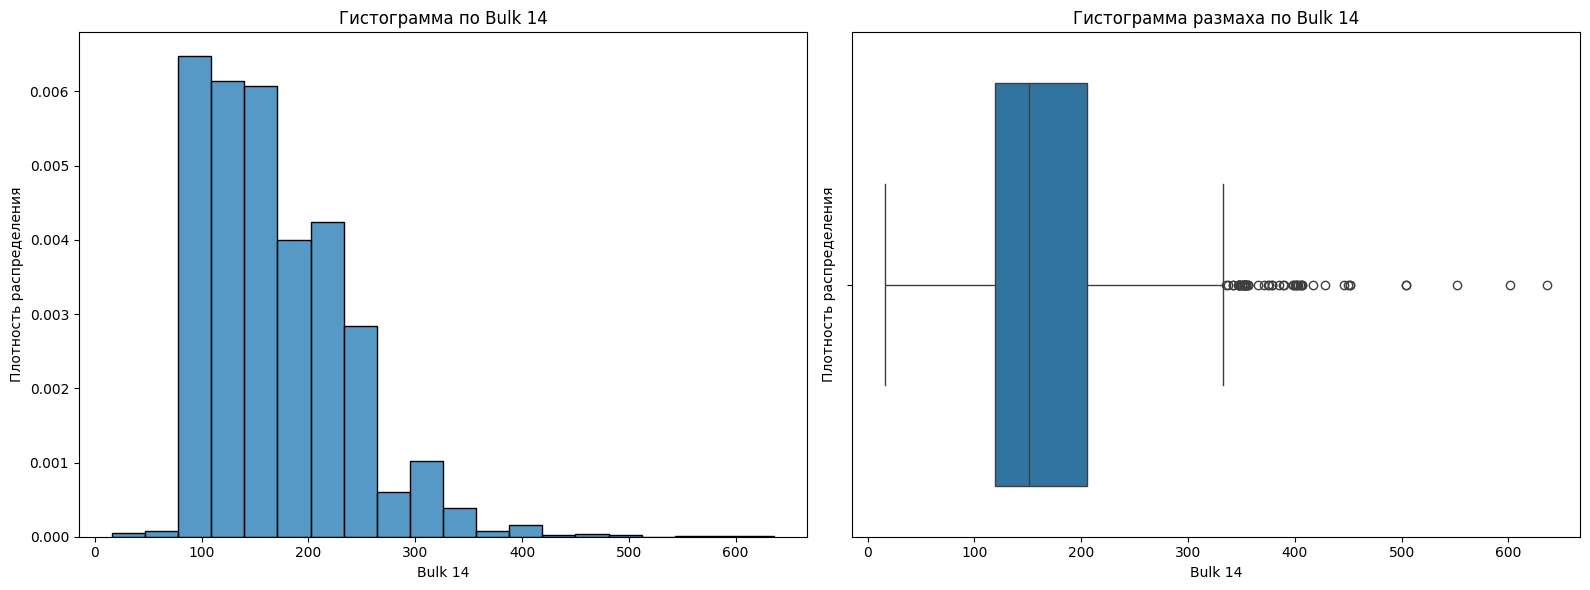

Визуализация числового признака: Bulk 15


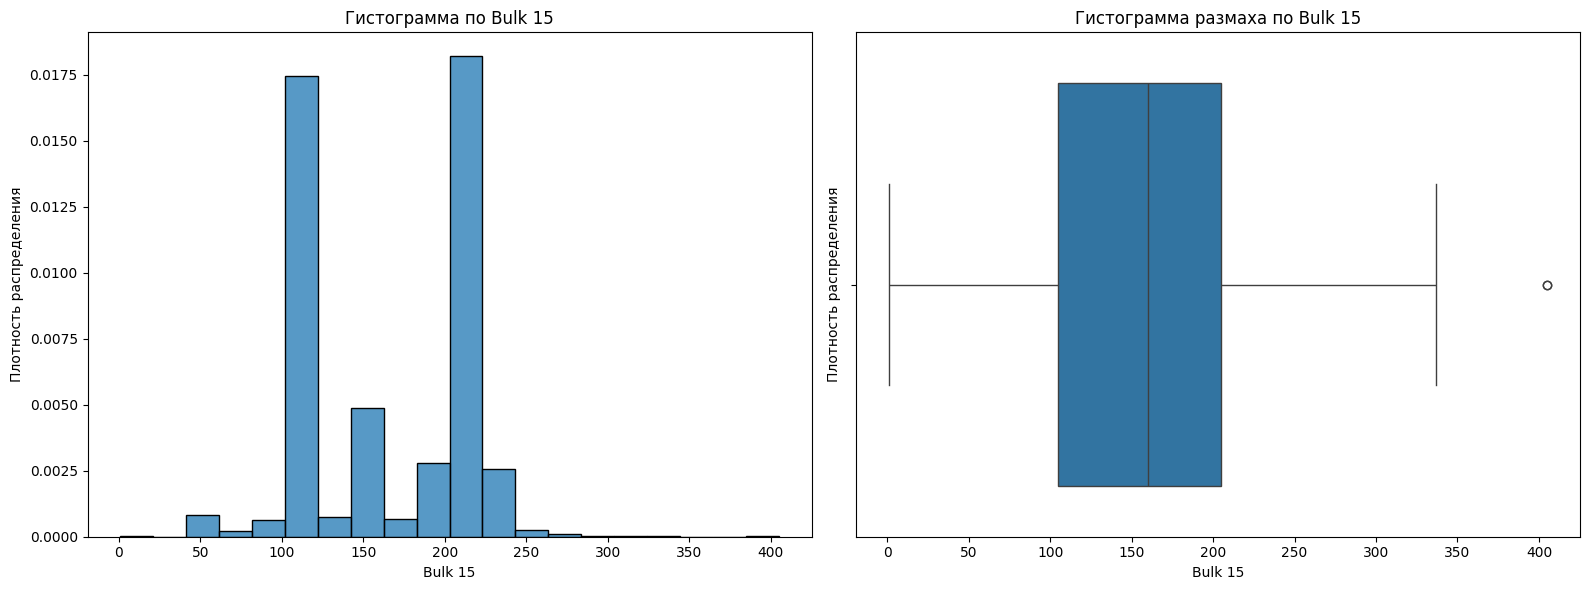

Визуализация числового признака: Bulk 3


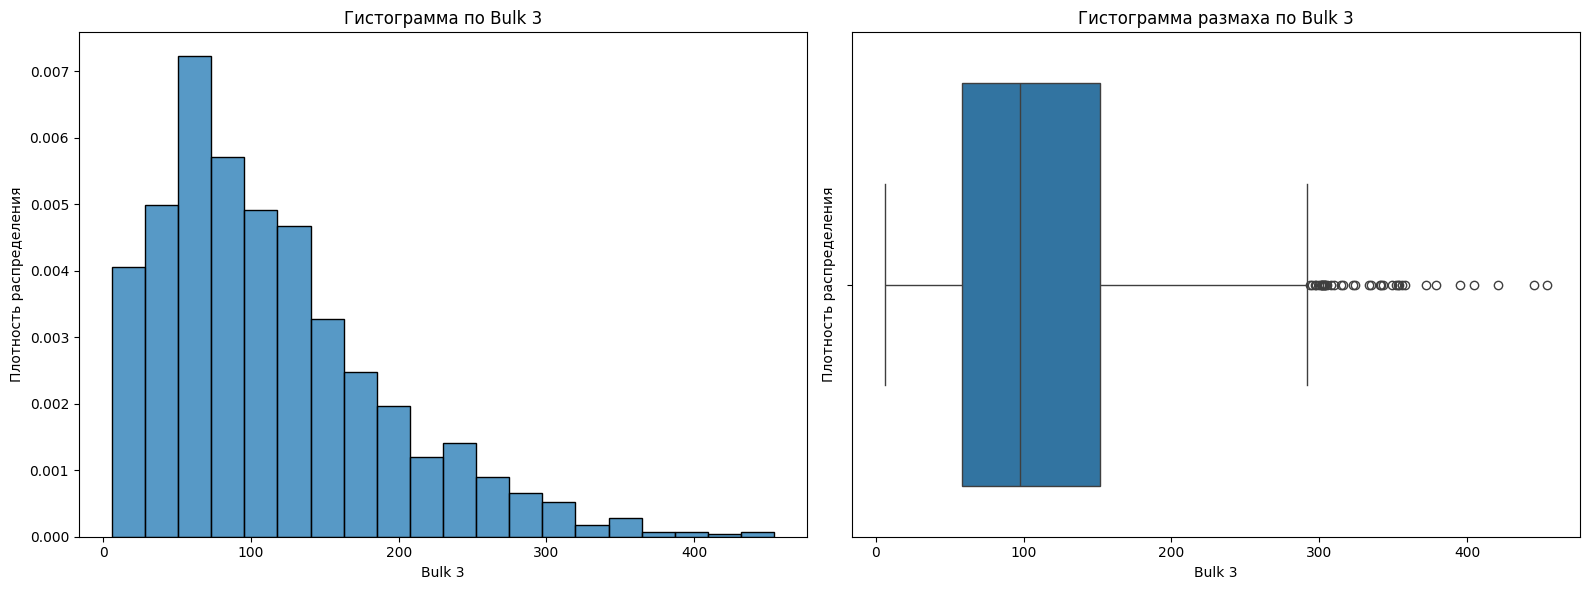

Визуализация числового признака: Bulk 4


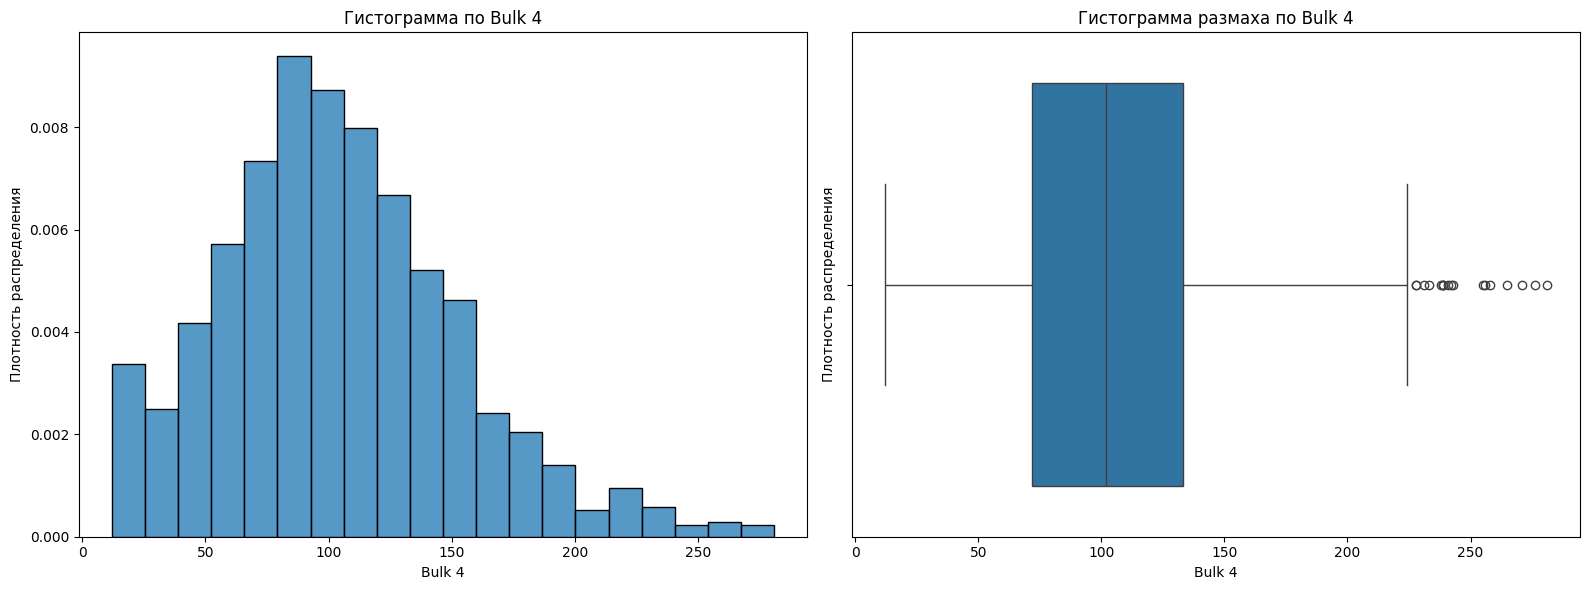

Визуализация числового признака: Bulk 6


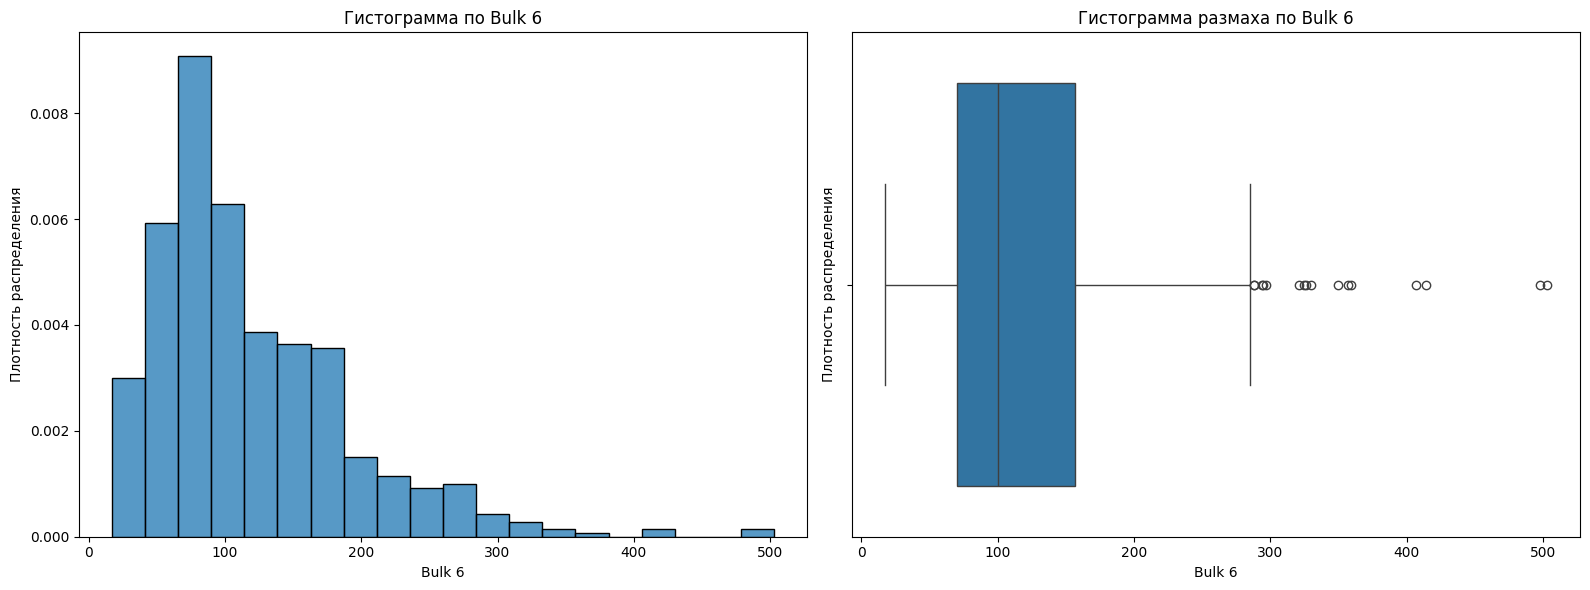

Визуализация числового признака: BulkCount


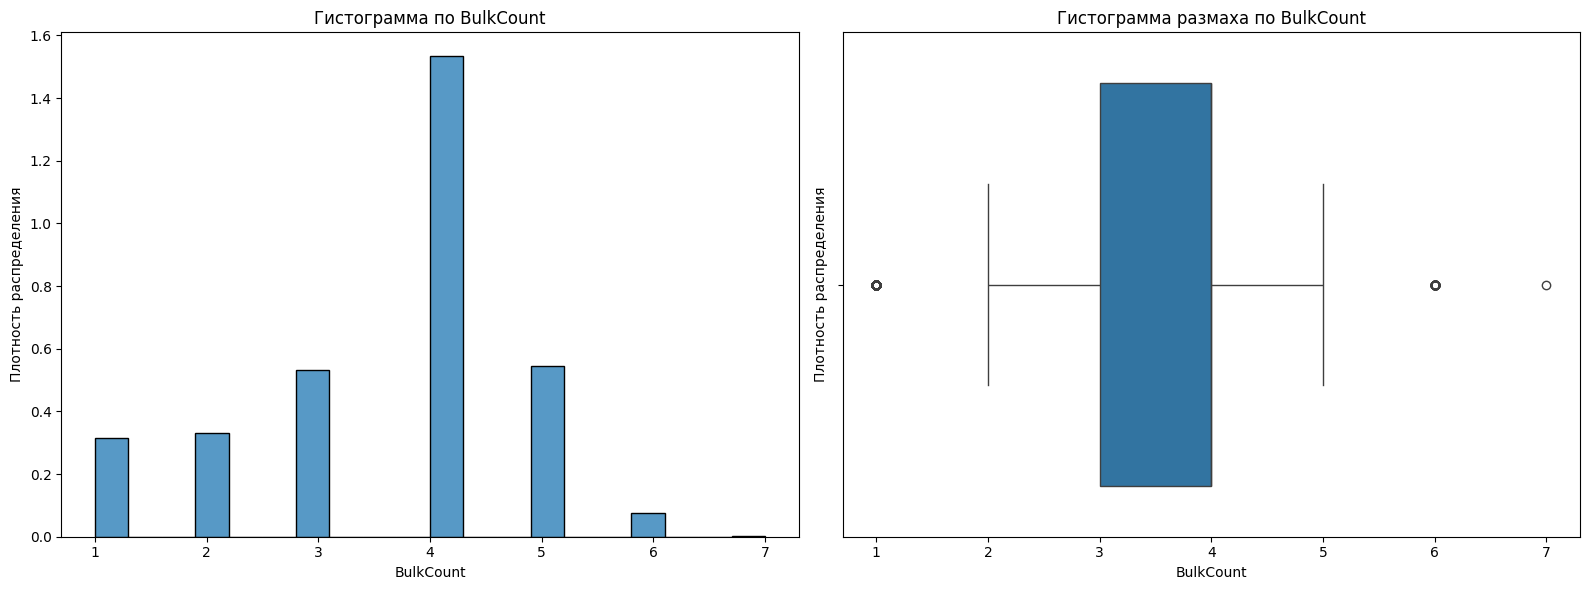

Визуализация числового признака: FullBulk


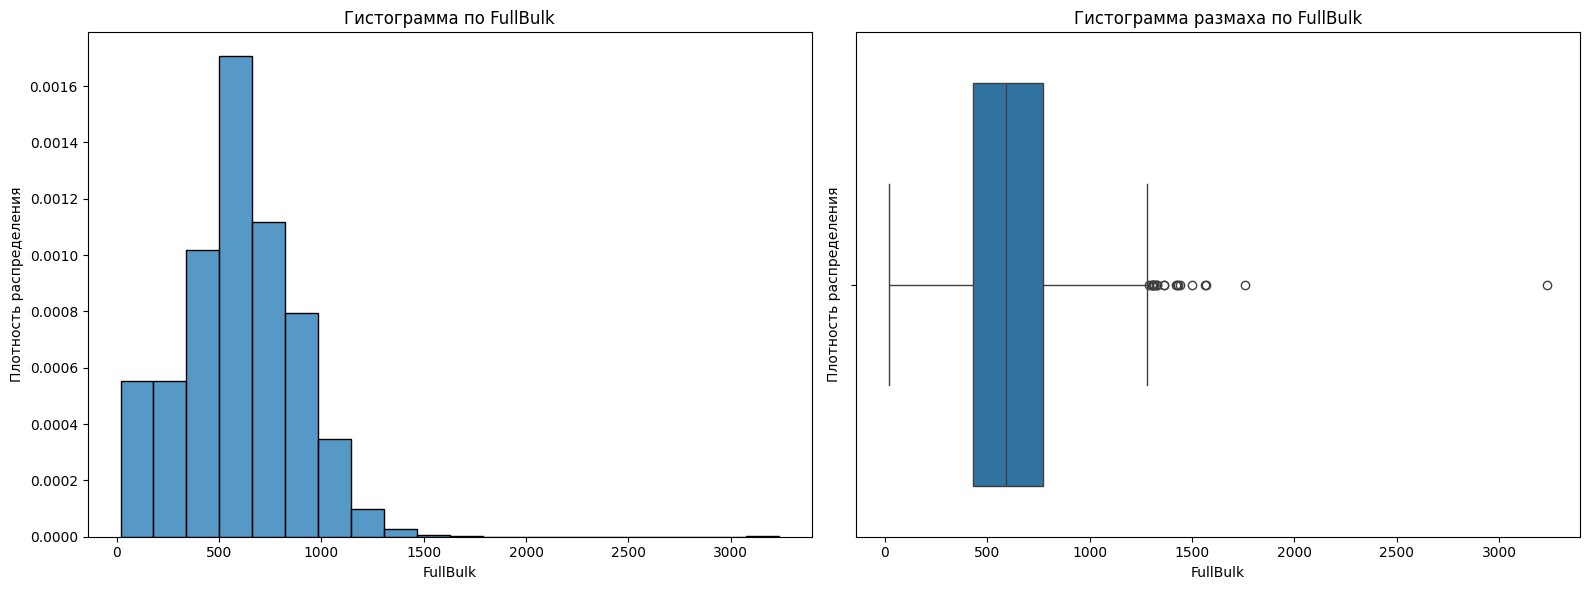

In [156]:
# Визуализируем признаки датасета data_bulk

all_diag(data_bulk_v2[cols_keep], column_type='numeric')

В объеме сыпучих материалов по партиям много пропусков, по условию задачи если есть пропуск значит материалы не добавлялись. Заменим пропуски нулями.

Проанализируем графики:
- Bulk 3 - Сильно скошено вправо, основная масса в диапазоне 0-150, хвост до 400+. Признак оставляем.
- Bulk 4 - Основные значения 50-130, пик около 80-100, хвост до 250-270. Признак оставляем.
- Bulk 6 - Похоже на Bulk 5: максимум около 100, редкие значения до 400-500. Признак оставляем.
- Bulk 12 - Очень сильная асимметрия, основная масса 100-400, но есть значения до 1800. Признак оставляем.
- Bulk 14 - Большинство в 80–220, пик 100-150, хвост до 600. Признак оставляем.
- Bulk 15 - Двухпиковое распределение (120 и 200), выбросы > 350. Признак оставляем.
- FullBulk - Распределение правостороннее, основная масса значений сосредоточена в диапазоне 300-1000. После 1000 частота резко падает, но встречаются отдельные выбросы до 3000. Признак оставляем.
- BulkCount - Сыпучие материалы подавались от 1 до 7 раз. Пик в 4. Признак оставляем.

#### data_bulk_time - данные о времени подачи сыпучих материалов;

- Проведем исследовательский анализ данных: проверьте наличие пропусков и аномалий, изучите распределение признаков.
- Проверим данные на адекватность: например, убедитесь, что подача материала не измеряется сутками. Обратим внимание: перед нами не стоит задача временных рядов.

Визуализация данных по времени начала плавок нам ничего не даст, поэтому перед анализом создадим новые колонки с временем между плавками и общей продолжительностью плавок.

In [157]:
# Создадим копию

data_bulk_time_v2 = data_bulk_time.copy()

In [158]:
# Преобразуем колонки в формат datetime

cols = [c for c in data_bulk_time_v2.columns if c != "key"]
data_bulk_time_v2[cols] = data_bulk_time_v2[cols].apply(pd.to_datetime, errors='coerce')

In [159]:
# Добавим колонки с продолжительностью плавки

data_bulk_time_v2["StartTime"] = data_bulk_time_v2[cols].min(axis=1)
data_bulk_time_v2["EndTime"] = data_bulk_time_v2[cols].max(axis=1)
data_bulk_time_v2["FullBulkTime"] = (data_bulk_time_v2["EndTime"] - data_bulk_time_v2["StartTime"]).dt.total_seconds()

In [160]:
# Удалим лишние колонки

data_bulk_time_v2 = data_bulk_time_v2.drop(columns=cols+["StartTime", "EndTime"])

Визуализация числового признака: FullBulkTime


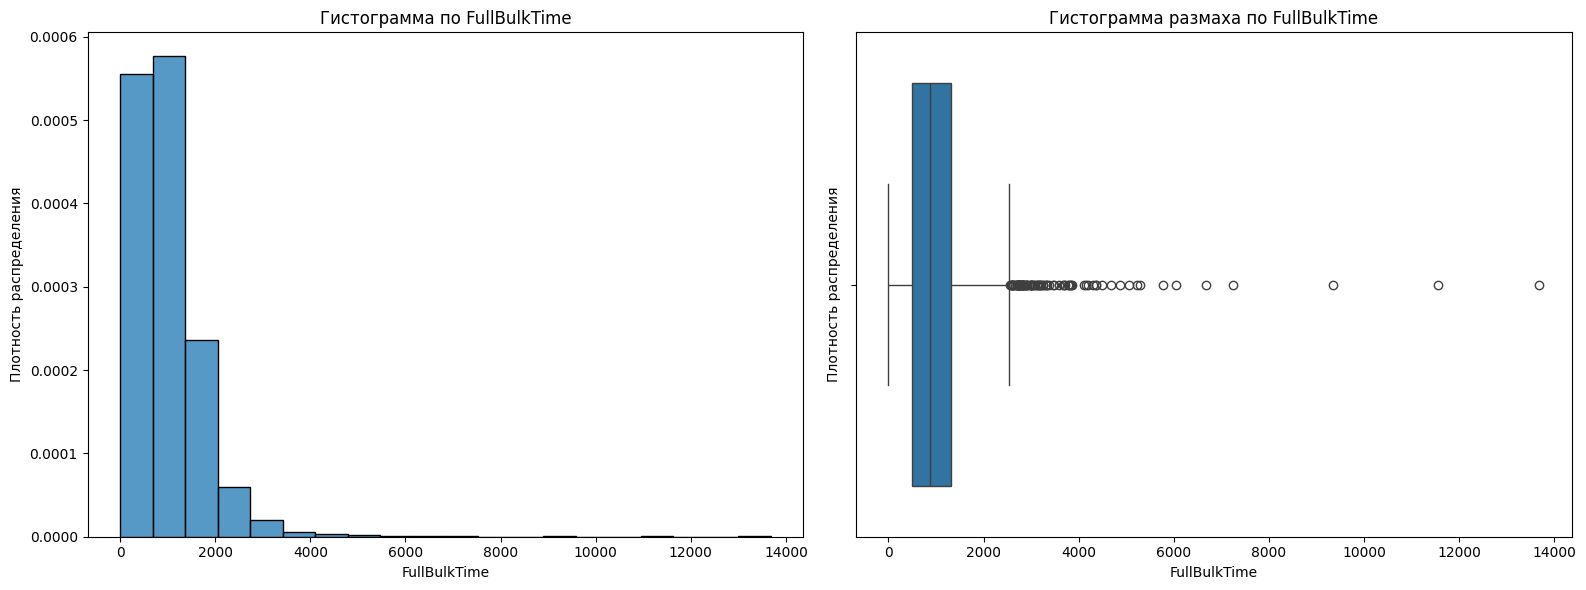

In [161]:
# Визуализируем признаки датасета data_bulk

all_diag(data_bulk_time_v2.drop(columns=["key"]))

Проанализируем графики:

- FullBulkTime - основное время плавки 500-1500 секунд. Признак оставляем.

В сутках у нас 86400 секунд, продолжительность плавок выглядит адекватным.

#### data_gas - данные о продувке сплава газом

- Проведем исследовательский анализ данных: проверим наличие пропусков и аномалий, изучим распределение признаков.

In [162]:
# Сделаем копию

data_gas_v2 = data_gas.copy()

In [163]:
# Переименуем колонку Газ 1

data_gas_v2 = data_gas_v2.rename(columns={
    "Газ 1": "gas"
})

Визуализация числового признака: gas


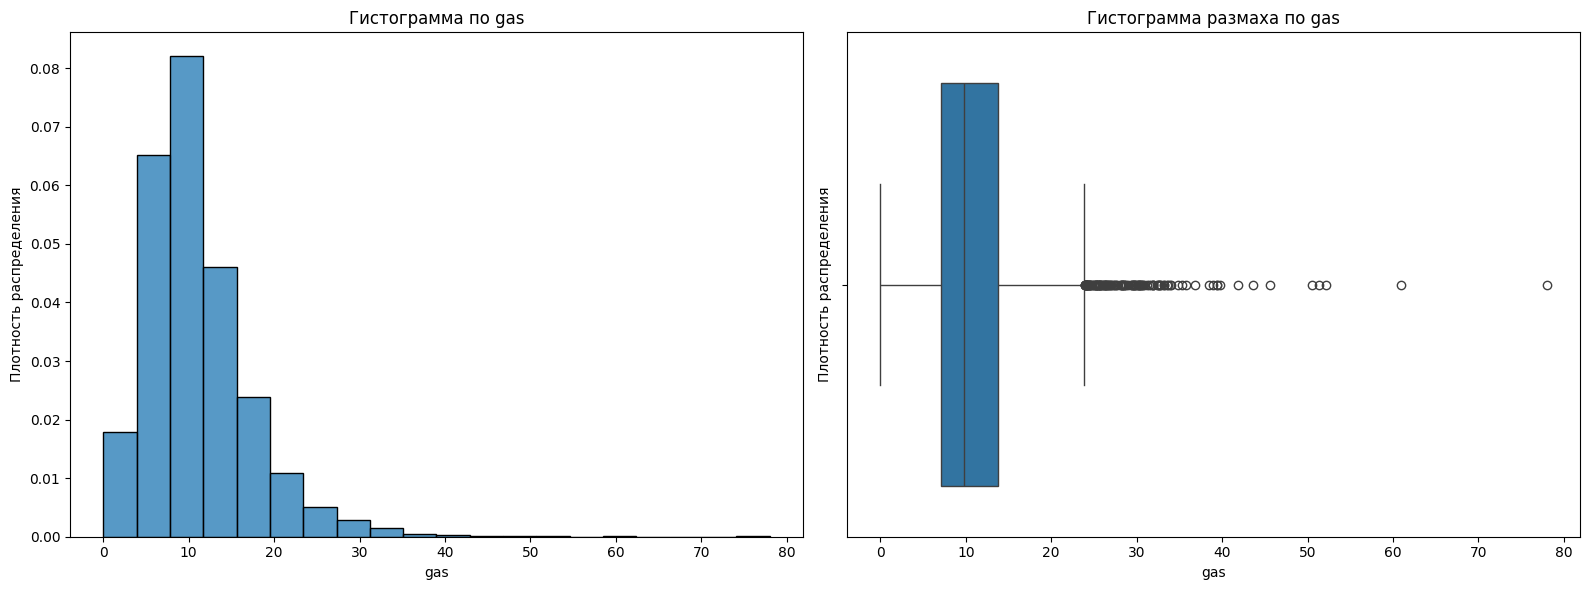

In [164]:
# Визуализируем датасет data_gas_v2

all_diag(data_gas_v2.drop(columns=["key"]))

Проанализируем график:
- gas - Основная масса значений находится в диапазоне 5-15, где наблюдается пик плотности. После 20 частота быстро снижается, но встречаются редкие экстремальные выбросы до 70–80. Признак оставляем.

#### data_temp - данные об измерениях температуры

- Проведем исследовательский анализ данных: проверим наличие пропусков и аномалий, изучим распределения признаков.
- Целевой признак - последняя температура партии. Начальную температуру партии можно использовать как входной признак. Любые другие промежуточные значения температуры приведут к утечке целевого признака, их нельзя использовать как входные.
- При агрегировании наблюдений используем только ключи, у которых как минимум два наблюдения: первый и последний замеры температуры.
- Заказчик предупредил, что значения температуры ниже 1500 градусов - аномальные.

In [165]:
# Сделаем копию

data_temp_v2 = data_temp.copy()

In [166]:
# Переименуем колонки

data_temp_v2 = data_temp_v2.rename(columns={
    "Время замера": "MeasureTime",
    "Температура": "Temperature"
})

In [167]:
# Приведем все столбцы с температурой к типу числовому типу а столбцы с временем замера к datetime

data_temp_v2["Temperature"] = data_temp_v2["Temperature"].apply(pd.to_numeric, errors='coerce')
data_temp_v2["MeasureTime"] = data_temp_v2["MeasureTime"].apply(pd.to_datetime, errors='coerce')

In [168]:
# Сортируем по ключу и времени

data_temp_v2 = data_temp_v2.sort_values(["key", "MeasureTime"])

In [169]:
# Группируем и находим первую и последнюю температуру

data_temp_agg = (
    data_temp_v2.groupby("key")["Temperature"]
    .agg(
        TempStart=lambda s: s.iloc[0],
        TempEnd  =lambda s: s.iloc[-1]
    )
    .reset_index()
)

In [170]:
# Найдем ключи, у которых нет конечной температуры

bad_keys = data_temp_agg.loc[data_temp_agg["TempEnd"].isna(), "key"].unique()
print(f"Ключей с пустой TempEnd: {len(bad_keys)}")

Ключей с пустой TempEnd: 739


In [171]:
# Почистим датасет от таких ключей

data_temp_agg = (
    data_temp_agg[~data_temp_agg["key"].isin(bad_keys)]
    .reset_index(drop=True)
)

Визуализация числового признака: TempStart


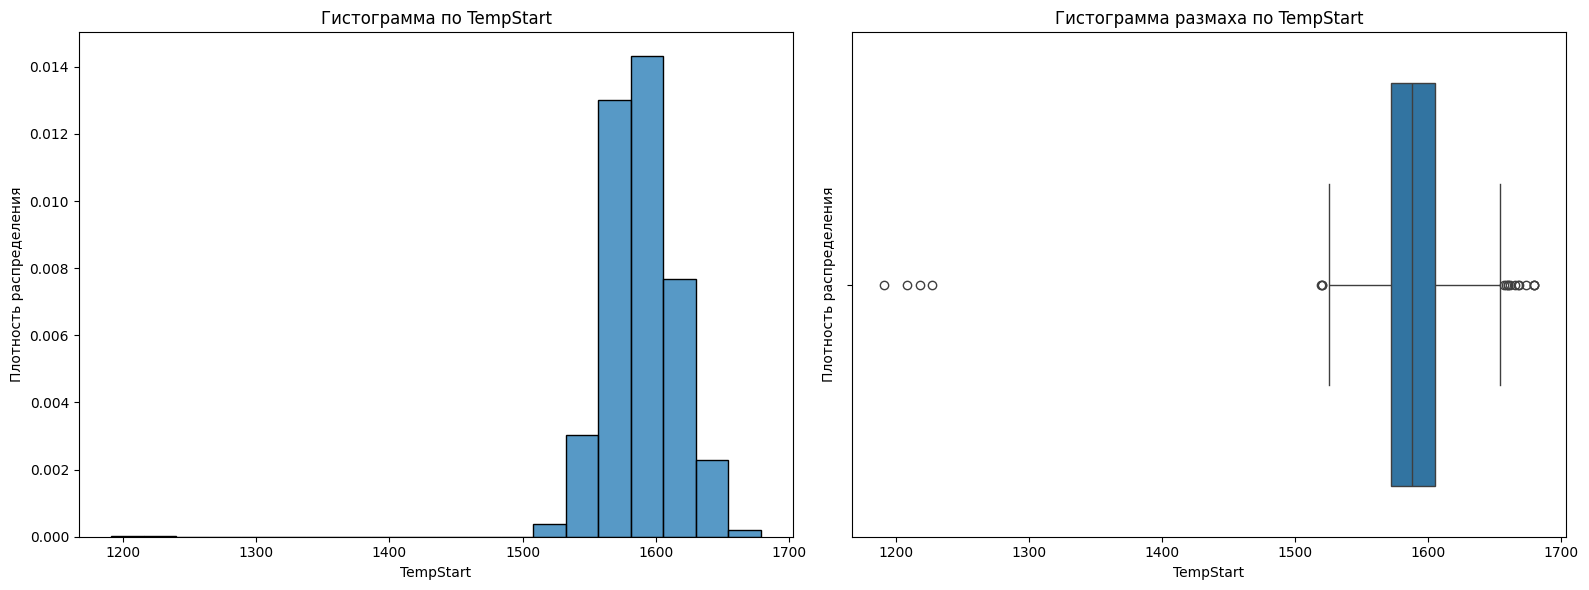

Визуализация числового признака: TempEnd


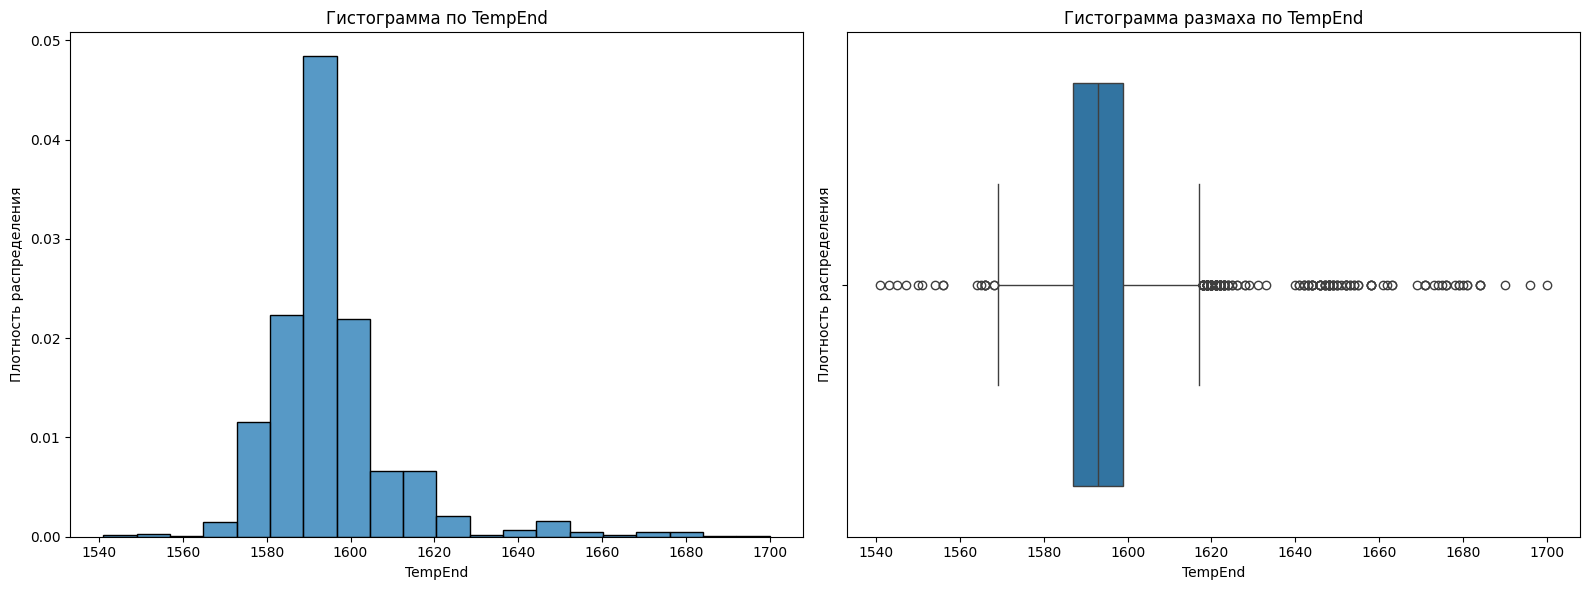

In [172]:
# Визуализируем датасет data_temp_agg

all_diag(data_temp_agg.drop(columns=["key"]))

Проанализируем графики:

- TempStart - Основная масса значений - 1550–1600. Есть единичные выбросы в районе 1200–1300. Признак оставляем. Выбросы < 1500 удаляем.
- TempEnd - Распределение очень узкое, близкое к нормальному с пиком около 1600. Несколько точек < 1500 - это выбросы, мы их удаляем. По условию задачи это аномальные температуры. Это целевой признак.

#### data_wire - данные об объёме проволочных материалов

- Обработаем пропуски. Пропуск означает, что материал не добавляли в эту партию.

In [173]:
# Сделаем копию

data_wire_v2 = data_wire.copy()

In [174]:
# Приведем все столбцы к типу числовому типу

data_wire_v2 = data_wire_v2.apply(pd.to_numeric, errors='coerce')

In [175]:
# Добавим колонку с общим объемом проволочных материалов и количество раз которое они подавались

wire_cols = [f"Wire {i}" for i in range(1, 10)]
data_wire_v2["FullWire"] = data_wire_v2[wire_cols].sum(axis=1)
data_wire_v2["WireCount"] = data_wire_v2[wire_cols].notna().sum(axis=1)

In [176]:
# Оставляем столбцы, где доля пропусков < 90%

cols_keep = data_wire_v2.columns[data_wire_v2.notna().mean() >= 0.10]
cols_keep = cols_keep.difference(["key"])

Визуализация числового признака: FullWire


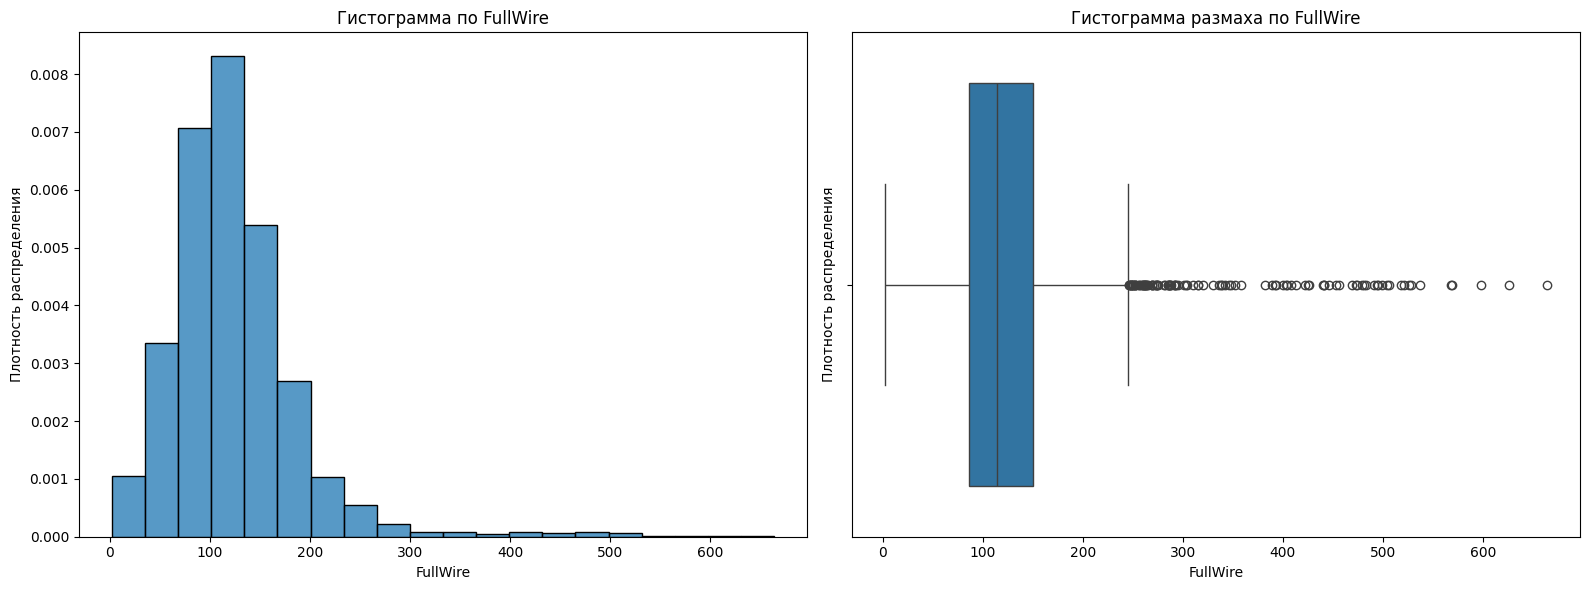

Визуализация числового признака: Wire 1


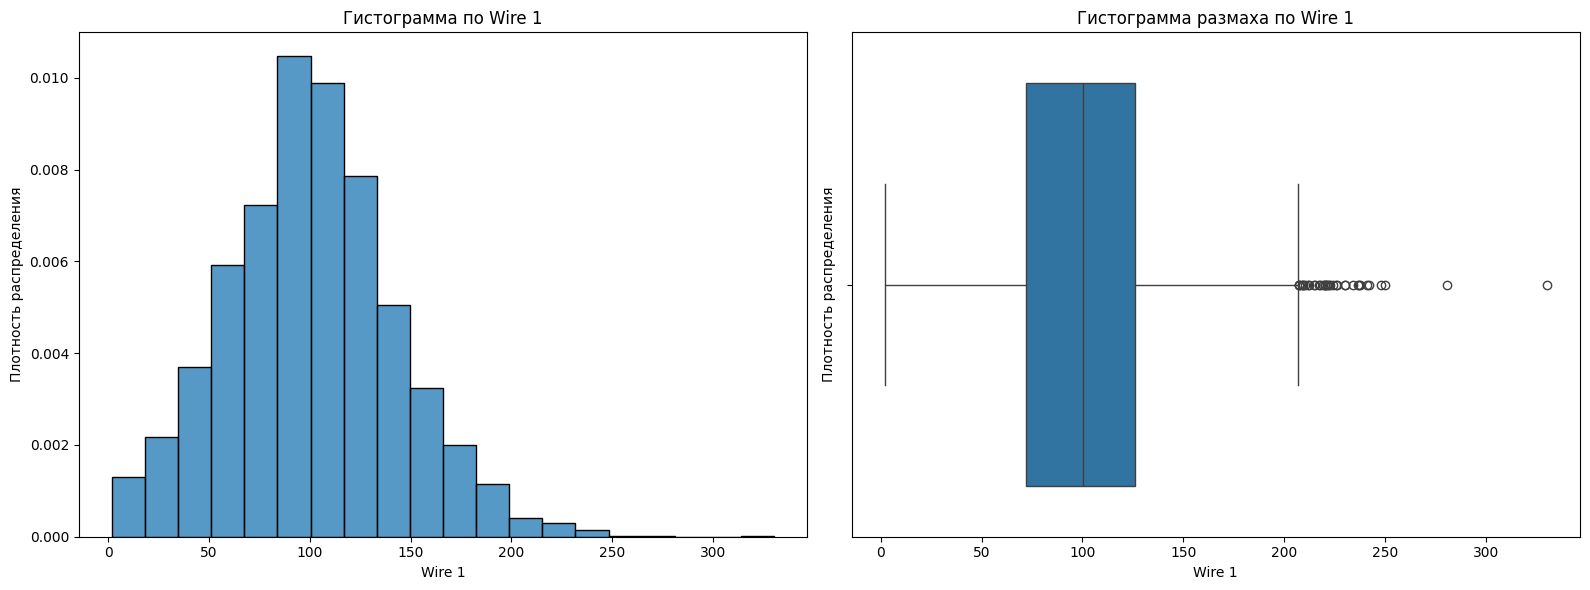

Визуализация числового признака: Wire 2


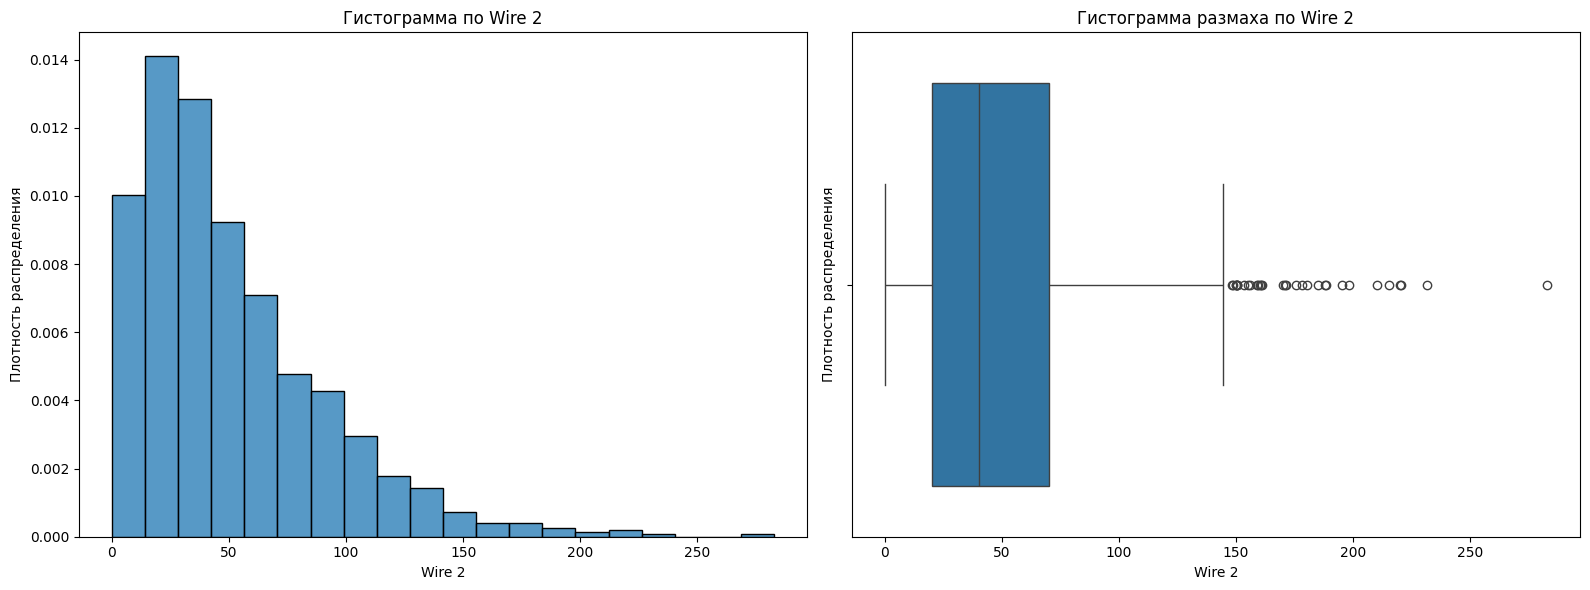

Визуализация числового признака: WireCount


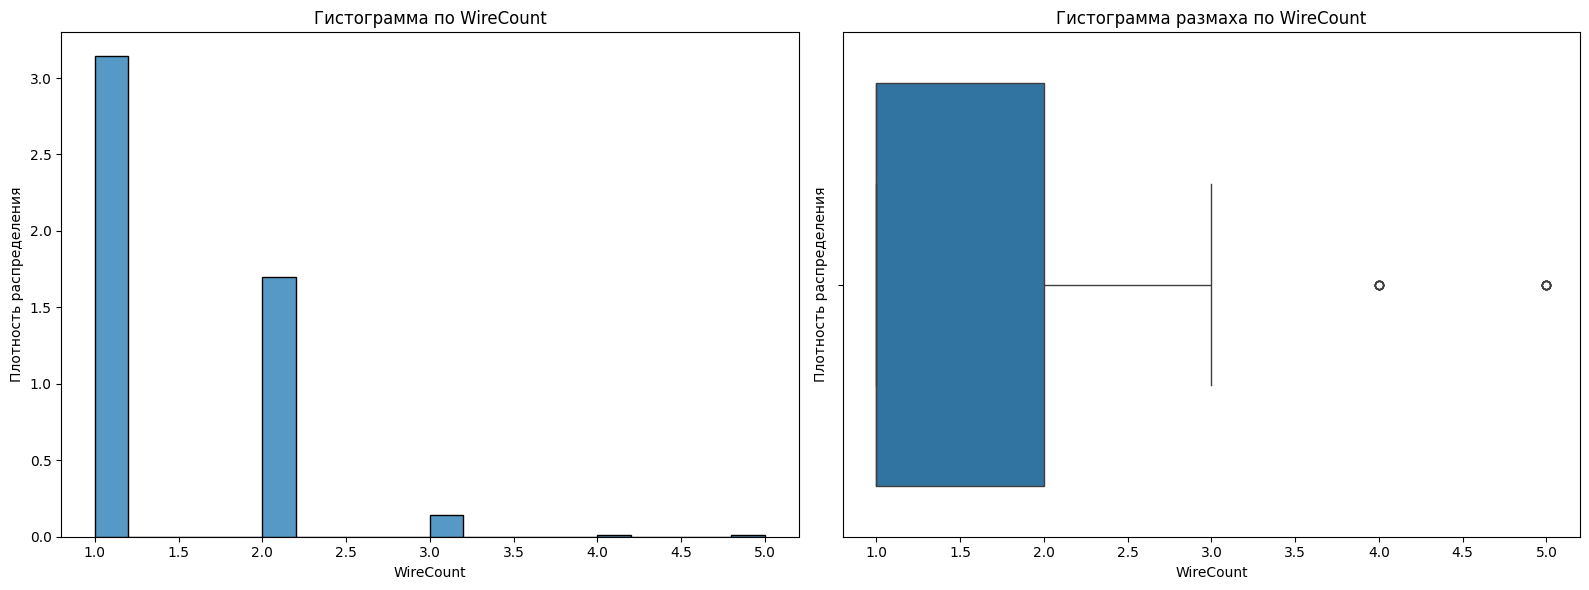

In [177]:
# Визуализируем признаки

all_diag(data_wire_v2[cols_keep])

Проанализируем графики:

- Wire 1 - Распределение умеренно скошено вправо. Большинство значений сосредоточено в диапазоне 50–130, пик наблюдается около 90–100. После 150 частота постепенно снижается, но встречаются редкие выбросы вплоть до 300. Признак оставляем.
- Wire 2 - Распределение сильно скошено вправо. Большинство значений находится в диапазоне 0–60, с пиком около 20–30. После 100 плотность быстро падает, но встречаются редкие выбросы до 250–270. Признак оставляем.
- FullWire - Распределение асимметричное, скошено вправо. Основной объем - 60–150. После 200–250 частота быстро падает, но есть выбросы до 600. Признак оставляем.
- WireCount - Проволочные материалы подавались от 1 до 5 раз. В основном 1-2 раза.

#### data_wire_time - данные о времени подачи проволочных материалов.

- Проведем исследовательский анализ данных: проверим наличие пропусков и аномалий, изучим распределение признаков.
- Проверьте данные на адекватность: например, убедимся, что подача материала не измеряется сутками. Обратим внимание: перед нами не стоит задача временных рядов.

In [178]:
# Сделаем копию

data_wire_time_v2 = data_wire_time.copy()

In [179]:
# Преобразуем колонки в формат datetime

cols = [c for c in data_wire_time_v2.columns if c != "key"]
data_wire_time_v2[cols] = data_wire_time_v2[cols].apply(pd.to_datetime, errors='coerce')

In [180]:
# Добавим колонки с временным промежутком в течение которого подавались проволочные материалы

data_wire_time_v2["StartTime"] = data_wire_time_v2[cols].min(axis=1)
data_wire_time_v2["EndTime"] = data_wire_time_v2[cols].max(axis=1)
data_wire_time_v2["FullWireTime"] = (data_wire_time_v2["EndTime"] - data_wire_time_v2["StartTime"]).dt.total_seconds()

In [181]:
# Удалим лишние колонки

data_wire_time_v2 = data_wire_time_v2.drop(columns=cols+["StartTime", "EndTime"])

Визуализация числового признака: FullWireTime


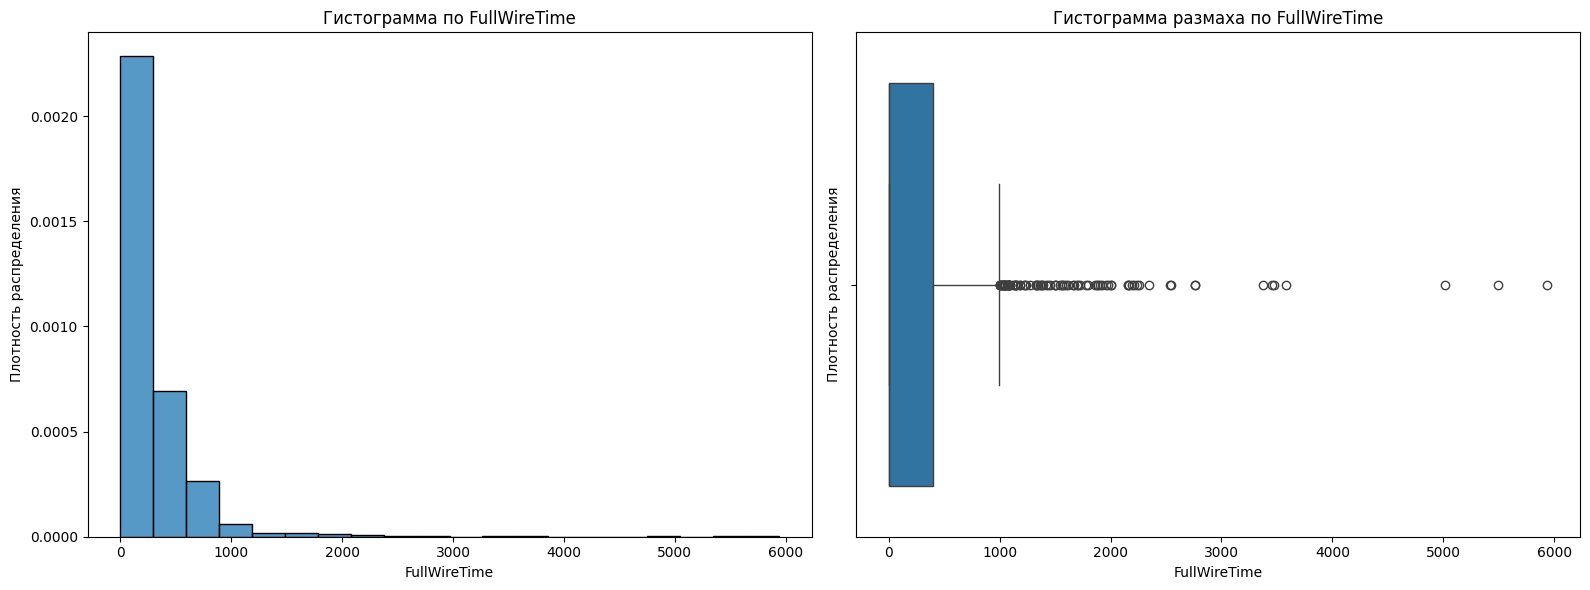

In [182]:
# Визуализируем данные

all_diag(data_wire_time_v2.drop(columns=["key"]))

Проанализируем графики:
- FullWireTime - т.к. у нас обычно проволочные материалы подавались 1 раз то время между первой и последней подачей будет равно 0. Что мы и видим на графике. Думаю пока можно признак оставить.

### Предобработка

#### data_arc

In [183]:
# Посмотрим информацию о датасете

data_arc_v2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   key            14876 non-null  int64  
 1   ActivePower    14876 non-null  float64
 2   ReactivePower  14876 non-null  float64
 3   HeatDuration   14876 non-null  float64
 4   FullPower      14876 non-null  float64
 5   PowerRatio     14876 non-null  float64
 6   HeatCount      14876 non-null  int64  
dtypes: float64(5), int64(2)
memory usage: 813.7 KB


In [184]:
# Создаем копию

data_arc_clean = data_arc_v2.copy()

In [185]:
# Агрегируем данные

agg_dict_ext = {
    "ActivePower": ["mean", "std", "max"],
    "ReactivePower": ["mean", "std", "max"],
    "FullPower": ["mean", "std", "max"],
    "HeatDuration": ["sum", "mean", "std", "max"],
    "PowerRatio": ["mean", "std", "max"]
}

data_arc_clean = (
    data_arc_clean
    .groupby("key", as_index=False)
    .agg(agg_dict_ext)
)

data_arc_clean.columns = ["_".join(col).rstrip("_") for col in data_arc_clean.columns]

In [186]:
# Посмотрим что получилось

data_arc_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   key                 3214 non-null   int64  
 1   ActivePower_mean    3214 non-null   float64
 2   ActivePower_std     3175 non-null   float64
 3   ActivePower_max     3214 non-null   float64
 4   ReactivePower_mean  3214 non-null   float64
 5   ReactivePower_std   3175 non-null   float64
 6   ReactivePower_max   3214 non-null   float64
 7   FullPower_mean      3214 non-null   float64
 8   FullPower_std       3175 non-null   float64
 9   FullPower_max       3214 non-null   float64
 10  HeatDuration_sum    3214 non-null   float64
 11  HeatDuration_mean   3214 non-null   float64
 12  HeatDuration_std    3175 non-null   float64
 13  HeatDuration_max    3214 non-null   float64
 14  PowerRatio_mean     3214 non-null   float64
 15  PowerRatio_std      3175 non-null   float64
 16  PowerR

У нас есть пропуски в std, это получилось из-за того, что стандартное отклонение не вычисляется для одного значения. Заполним эти пропуски нулями.

In [187]:
# Заполняем пропуски

data_arc_clean = data_arc_clean.fillna(0)

#### data_bulk

In [188]:
# Посмотрим информацию о датасете

data_bulk_v2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   key        3129 non-null   int64  
 1   Bulk 1     252 non-null    float64
 2   Bulk 2     22 non-null     float64
 3   Bulk 3     1298 non-null   float64
 4   Bulk 4     1014 non-null   float64
 5   Bulk 5     77 non-null     float64
 6   Bulk 6     576 non-null    float64
 7   Bulk 7     25 non-null     float64
 8   Bulk 8     1 non-null      float64
 9   Bulk 9     19 non-null     float64
 10  Bulk 10    176 non-null    float64
 11  Bulk 11    177 non-null    float64
 12  Bulk 12    2450 non-null   float64
 13  Bulk 13    18 non-null     float64
 14  Bulk 14    2806 non-null   float64
 15  Bulk 15    2248 non-null   float64
 16  FullBulk   3129 non-null   float64
 17  BulkCount  3129 non-null   int64  
dtypes: float64(16), int64(2)
memory usage: 440.1 KB


Тут много пропусков. По условию задачи если NaN то сыпучие материалы не подавались. Заполняем пропуски нулями. Если в столбце более 90% пропусков, то такие столбцы мы также удалим.

In [189]:
# Создаем копию

data_bulk_clean = data_bulk_v2.copy()

In [190]:
# Удаляем столбцы с пропусками более 90% значений

thr = 0.90

na_ratio = data_bulk_clean.isna().mean()
cols_to_drop = na_ratio[na_ratio > thr].index.tolist()

print(cols_to_drop)

['Bulk 1', 'Bulk 2', 'Bulk 5', 'Bulk 7', 'Bulk 8', 'Bulk 9', 'Bulk 10', 'Bulk 11', 'Bulk 13']


In [191]:
# Удаляем столбца с пропусками более 90%

data_bulk_clean = data_bulk_clean.drop(columns=cols_to_drop)

In [192]:
# Заполняем пропуски нулями по условию задачи

data_bulk_clean = data_bulk_clean.fillna(0)

#### data_bulk_time

In [193]:
# Посмотрим информацию о датасете

data_bulk_time_v2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           3129 non-null   int64  
 1   FullBulkTime  3129 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 49.0 KB


In [194]:
# Создаем копию

data_bulk_time_clean = data_bulk_time_v2.copy()

#### data_gas

In [195]:
# Посмотрим информацию о датасете

data_gas_v2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   gas     3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


In [196]:
# Создаем копию

data_gas_clean = data_gas_v2.copy()

#### data_temp

Удаляем:

- TempStart < 1500
- TempEnd < 1500

In [197]:
# Посмотрим информацию о датасете

data_temp_agg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2477 entries, 0 to 2476
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   key        2477 non-null   int64  
 1   TempStart  2477 non-null   float64
 2   TempEnd    2477 non-null   float64
dtypes: float64(2), int64(1)
memory usage: 58.2 KB


In [198]:
# Создаем копию

data_temp_clean = data_temp_agg.copy()

In [199]:
# Чистим датасет

data_temp_clean = data_temp_clean.loc[
    (data_temp_clean["TempStart"] >= 1500) &
    (data_temp_clean["TempEnd"] >= 1500)
]

In [200]:
# Посмотрим что получилось после очистки

loss_pct = (1 - data_temp_clean.shape[0] / data_temp_agg.shape[0]) * 100
print(f"Было: {data_temp_agg.shape}")
print(f"Стало: {data_temp_clean.shape}")
print(f"Потери: {loss_pct:.2f}%")

Было: (2477, 3)
Стало: (2473, 3)
Потери: 0.16%


#### data_wire

In [201]:
# Посмотрим информацию о датасете

data_wire_v2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   key        3081 non-null   int64  
 1   Wire 1     3055 non-null   float64
 2   Wire 2     1079 non-null   float64
 3   Wire 3     63 non-null     float64
 4   Wire 4     14 non-null     float64
 5   Wire 5     1 non-null      float64
 6   Wire 6     73 non-null     float64
 7   Wire 7     11 non-null     float64
 8   Wire 8     19 non-null     float64
 9   Wire 9     29 non-null     float64
 10  FullWire   3081 non-null   float64
 11  WireCount  3081 non-null   int64  
dtypes: float64(10), int64(2)
memory usage: 289.0 KB


In [202]:
# Создаем копию

data_wire_clean = data_wire_v2.copy()

In [203]:
# Найдем столбцы с пропусками более 90% значений

na_ratio = data_wire_clean.isna().mean()
cols_to_drop = na_ratio[na_ratio > thr].index.tolist()

print(cols_to_drop)

['Wire 3', 'Wire 4', 'Wire 5', 'Wire 6', 'Wire 7', 'Wire 8', 'Wire 9']


In [204]:
# Удаляем столбцы с пропусками более 90% значений

data_wire_clean = data_wire_clean.drop(columns=cols_to_drop)

In [205]:
# Заполняем пропуски нулями по условию задачи

data_wire_clean = data_wire_clean.fillna(0)

#### data_wire_time

In [206]:
# Посмотрим информацию о датасете

data_wire_time_v2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           3081 non-null   int64  
 1   FullWireTime  3081 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 48.3 KB


In [207]:
# Создаем копию

data_wire_time_clean = data_wire_time_v2.copy()

#### Объединение данных

In [208]:
# Объединим датасеты по ключу

merged = (data_temp_clean
          .merge(data_arc_clean, on='key')
          .merge(data_bulk_clean, on='key')
          .merge(data_bulk_time_clean, on='key')
          .merge(data_gas_clean, on='key')
          .merge(data_wire_clean, on='key')
          .merge(data_wire_time_clean, on='key'))

In [209]:
# Посмотрим датасет

merged.head()

,key,TempStart,TempEnd,ActivePower_mean,ActivePower_std,ActivePower_max,ReactivePower_mean,ReactivePower_std,ReactivePower_max,FullPower_mean,...,Bulk 15,FullBulk,BulkCount,FullBulkTime,gas,Wire 1,Wire 2,FullWire,WireCount,FullWireTime
0,1,1571.0,1613.0,0.607346,0.219381,0.867133,0.428564,0.156729,0.643691,1.035910,...,154.0,553.0,4,1085.0,29.749986,60.059998,0.00000,60.059998,1,0.0
1,2,1581.0,1602.0,0.534852,0.253168,0.786322,0.363339,0.175354,0.542517,0.898191,...,154.0,582.0,4,1000.0,12.555561,96.052315,0.00000,96.052315,1,0.0
2,3,1596.0,1599.0,0.812728,0.346076,1.222963,0.587491,0.249668,0.863676,1.400220,...,153.0,544.0,4,983.0,28.554793,91.160157,0.00000,91.160157,1,0.0
3,4,1601.0,1625.0,0.676622,0.267795,0.887855,0.514248,0.192282,0.654661,1.190870,...,154.0,595.0,4,878.0,18.841219,89.063515,0.00000,89.063515,1,0.0
4,5,1576.0,1602.0,0.563238,0.242293,0.892957,0.421998,0.173778,0.660807,0.985235,...,152.0,584.0,4,205.0,5.413692,89.238236,9.11456,98.352796,2,310.0


In [210]:
# Выведем информацию о датасете

merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2325 entries, 0 to 2324
Data columns (total 34 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   key                 2325 non-null   int64  
 1   TempStart           2325 non-null   float64
 2   TempEnd             2325 non-null   float64
 3   ActivePower_mean    2325 non-null   float64
 4   ActivePower_std     2325 non-null   float64
 5   ActivePower_max     2325 non-null   float64
 6   ReactivePower_mean  2325 non-null   float64
 7   ReactivePower_std   2325 non-null   float64
 8   ReactivePower_max   2325 non-null   float64
 9   FullPower_mean      2325 non-null   float64
 10  FullPower_std       2325 non-null   float64
 11  FullPower_max       2325 non-null   float64
 12  HeatDuration_sum    2325 non-null   float64
 13  HeatDuration_mean   2325 non-null   float64
 14  HeatDuration_std    2325 non-null   float64
 15  HeatDuration_max    2325 non-null   float64
 16  PowerR

### Корреляционный анализ

In [211]:
# Вычислим матрицу Phik для нашего датасета

phk_merged = merged.copy()
phk_merged = phk_merged.drop("key", axis=1)
phk = phk_merged.phik_matrix(verbose=False)

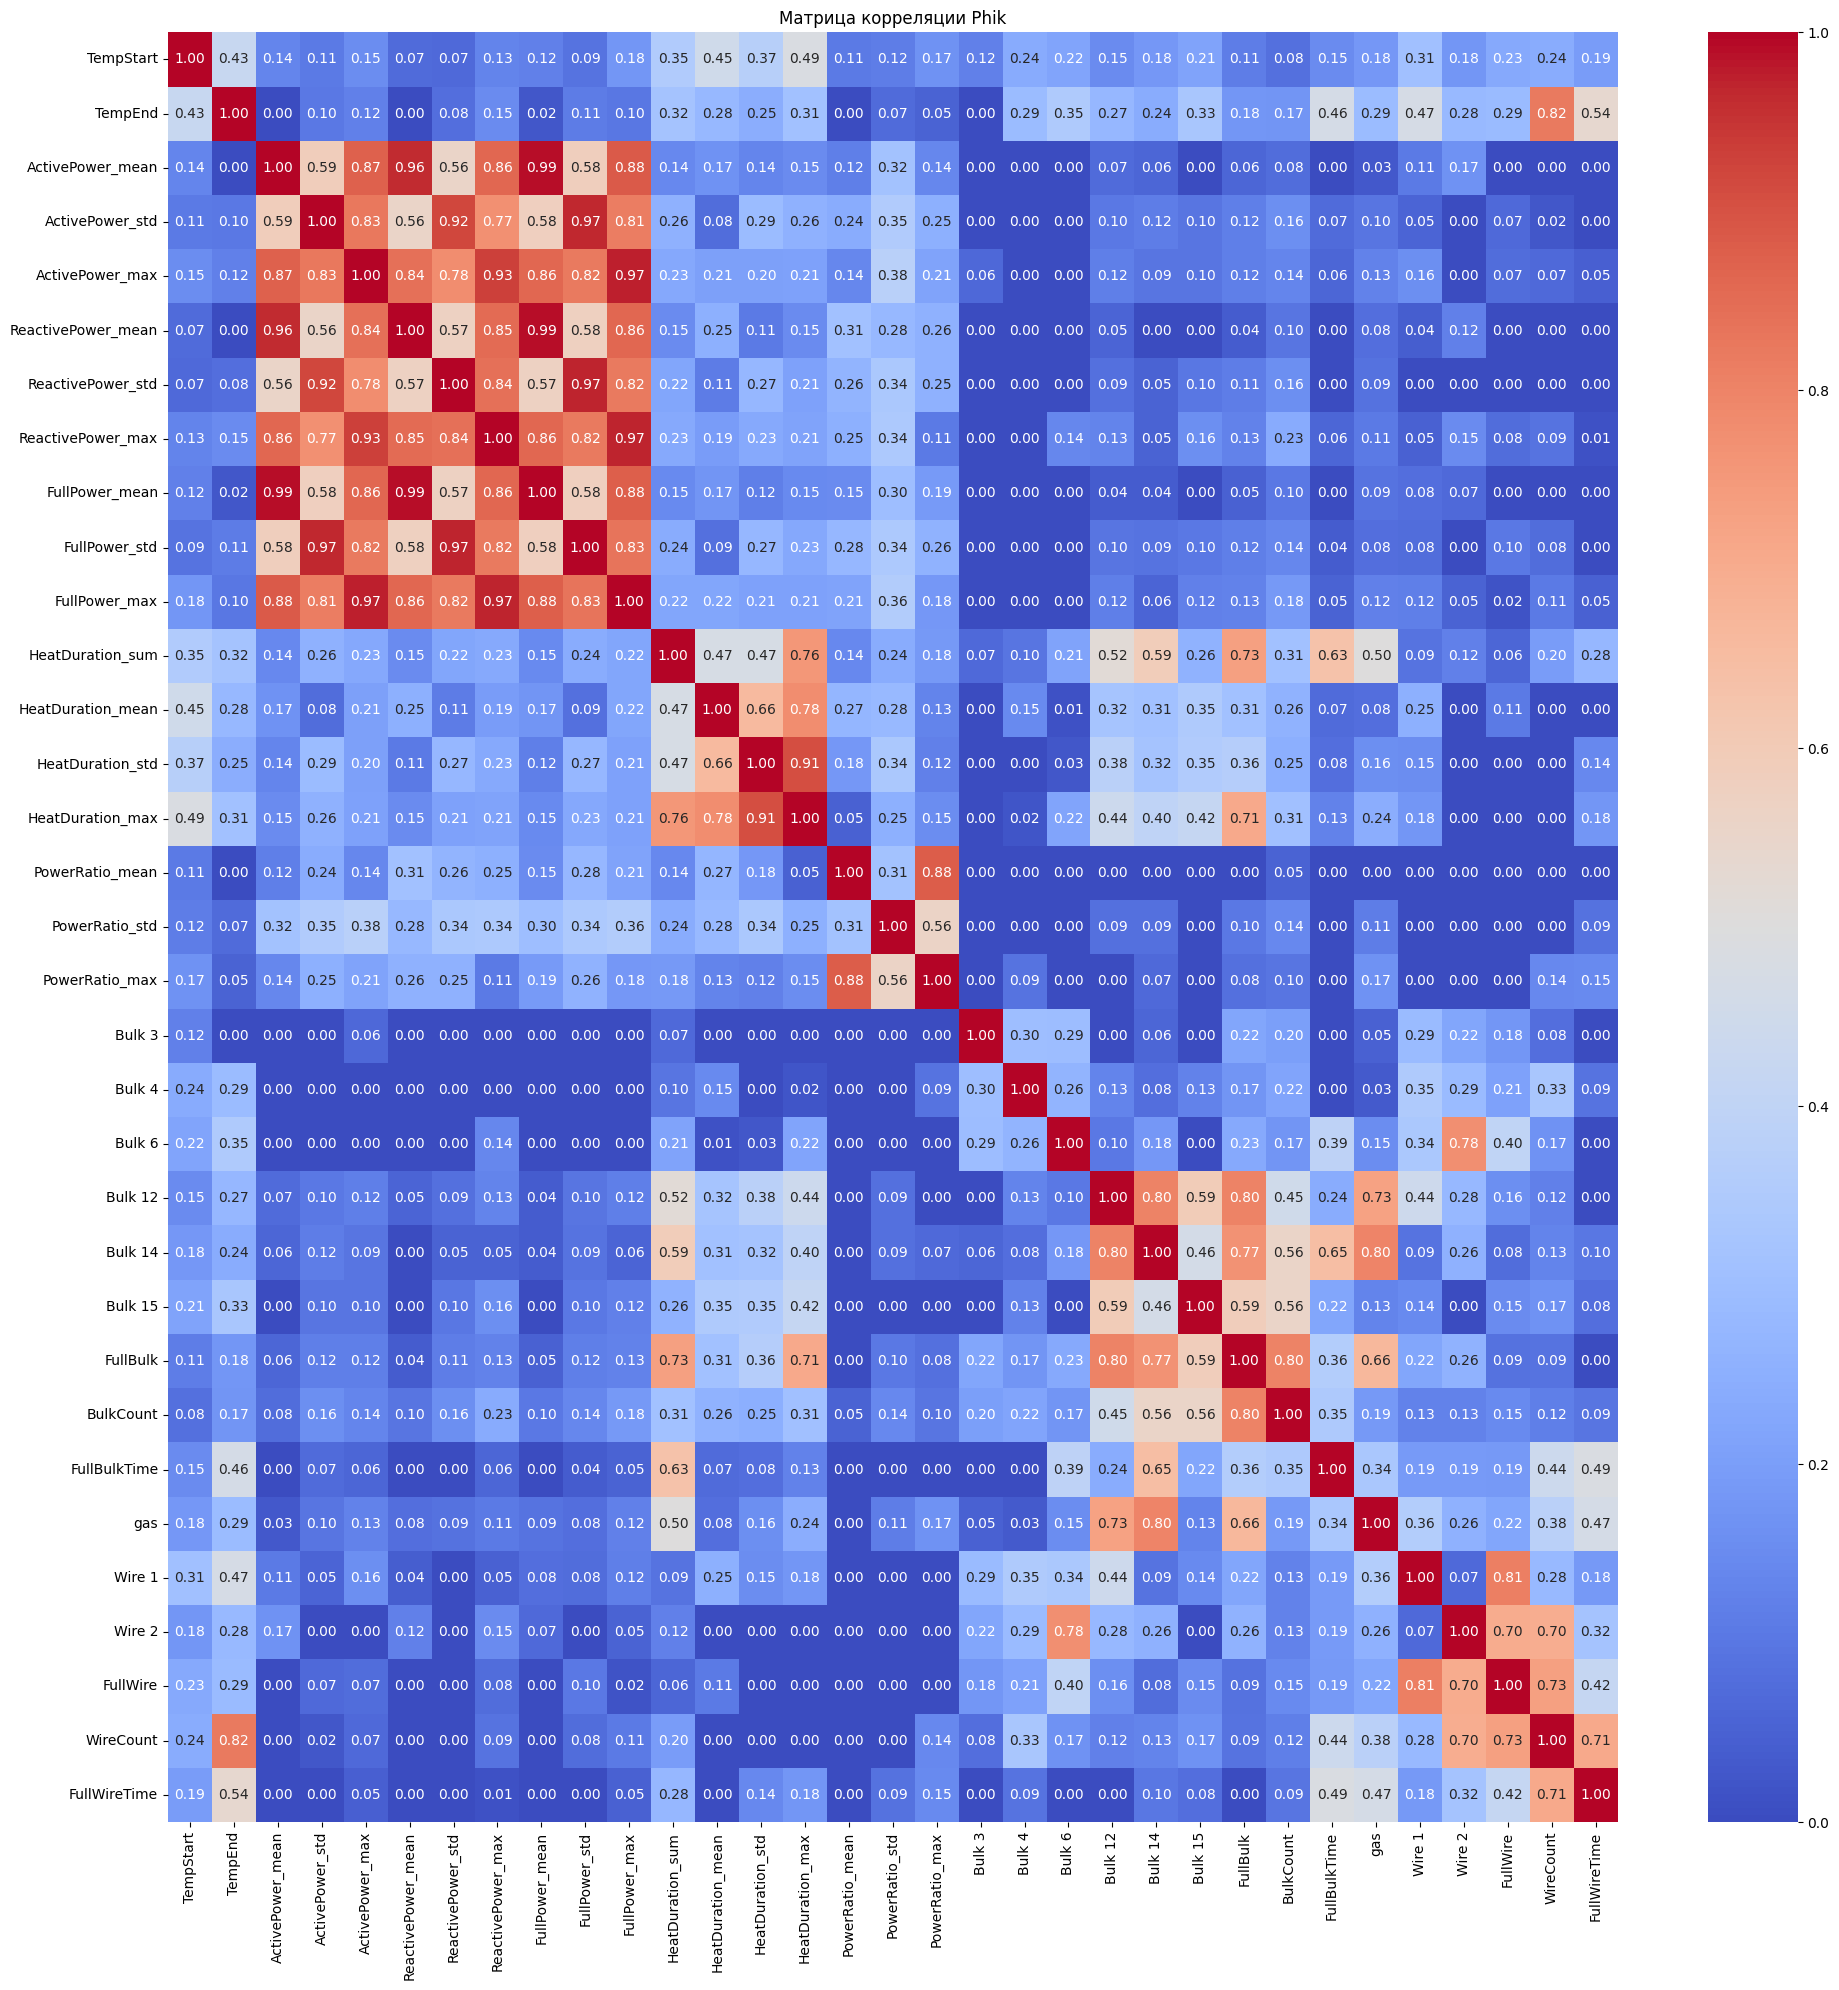

In [212]:
# Визуализируем матрицу корреляции

plt.figure(figsize=(20, 20))
plt.title('Матрица корреляции Phik')
sns.heatmap(phk, annot=True, cmap='coolwarm', fmt='.2f')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [213]:
# Берём только столбец корреляций с целевой переменной

phk_target = phk["TempEnd"].sort_values(ascending=False)

In [214]:
# Выведем ненулевые корреляции (где phik != 0)

nonzero_corr = phk_target[phk_target != 0].sort_values(ascending=False)
print("Ненулевые корреляции:")
print(nonzero_corr)

Ненулевые корреляции:
TempEnd              1.000000
WireCount            0.824218
FullWireTime         0.538139
Wire 1               0.470677
FullBulkTime         0.464844
TempStart            0.425179
Bulk 6               0.348244
Bulk 15              0.329095
HeatDuration_sum     0.317550
HeatDuration_max     0.309582
Bulk 4               0.291470
gas                  0.290724
FullWire             0.287962
Wire 2               0.282256
HeatDuration_mean    0.279736
Bulk 12              0.274205
HeatDuration_std     0.245313
Bulk 14              0.241233
FullBulk             0.177972
BulkCount            0.172728
ReactivePower_max    0.150896
ActivePower_max      0.123874
FullPower_std        0.112989
ActivePower_std      0.102453
FullPower_max        0.100984
ReactivePower_std    0.079619
PowerRatio_std       0.072976
PowerRatio_max       0.053985
FullPower_mean       0.024828
Name: TempEnd, dtype: float64


Топ-факторы коррелирующие с целевой переменной:
- WireCount (0.824) - Количество подач имеет умеренное влияние
- FullWireTime (0.538) - Общее время подачи проволоки
- Wire 1 (0.356) - Количество или масса первого типа проволоки сильно влияет на температуру
- FullBulkTime (0.464) - Общее время подачи проволоки
- TempStart (0.425) - Логично: чем выше начальная температура, тем выше и конечная
- Bulk 6, Bulk 15 (0.348, 0.329) - Конкретные сыпучие материалы имеют умеренное влияние - вероятно, участвуют в химических реакциях, влияющих на температуру
- HeatDuration_sum (0.317) - Чем дольше нагреваем тем выше температура
- HeatDuration_max (0.309) - Максимальная длительность нагрева умеренно влияет на конечную температуру
- Bulk 4 (0.291) - Конкретные сыпучие материалы имеют умеренное влияние - вероятно, участвуют в химических реакциях, влияющих на температуру
- gas (0.290) - Количество использования газа влияет на конечную температуру
- FullWire (0.287) - Общий объем проволоки влияет на температуру но гораздо слабее чем конкретная проволока Wire 1
- Wire 2 (0.282) - менее значимые добавки
- HeatDuration_mean (0.279) - Средняя длительность нагрева оказывает заметное влияние - чем дольше время нагрева тем выше температура
- Bulk 12 (0.274) - Конкретные сыпучие материалы имеют умеренное влияние - вероятно, участвуют в химических реакциях, влияющих на температуру
- HeatDuration_std (0.245) - Разброс длительности нагрева возможно отражает стабильность нагрева

Остальные признаки оказывают более слабое влияние.

In [215]:
# Выведем нулевые корреляции

zero_corr = phk_target[phk_target == 0]
print("Нулевые корреляции:")
print(zero_corr)

Нулевые корреляции:
Bulk 3                0.0
ReactivePower_mean    0.0
PowerRatio_mean       0.0
ActivePower_mean      0.0
Name: TempEnd, dtype: float64


Признаки с нулевой корреляцией к целевой переменной мы удалим

In [216]:
# Удалим ненужные колонки

df_vif = merged.copy().drop(columns=["key"])

In [217]:
# Масштабируем

X_scaled = StandardScaler().fit_transform(df_vif)
X_scaled = pd.DataFrame(X_scaled, columns=df_vif.columns)

In [218]:
# Добавляем константу

X_scaled_const = sm.add_constant(X_scaled)

In [219]:
# Считаем VIF

vif_data = pd.DataFrame({
    "feature": X_scaled_const.columns,
    "VIF": [variance_inflation_factor(X_scaled_const.values, i)
            for i in range(X_scaled_const.shape[1])]
})

/home/komap/tf-gpu/lib/python3.10/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


In [220]:
# Убираем саму константу из вывода

vif_data = vif_data[vif_data["feature"] != "const"]
vif_data.sort_values(by="VIF", ascending=False)

,feature,VIF
3,ActivePower_mean,inf
6,ReactivePower_mean,inf
9,FullPower_mean,inf
10,FullPower_std,2531.166201
11,FullPower_max,970.799104
4,ActivePower_std,864.810022
7,ReactivePower_std,563.879388
5,ActivePower_max,367.804695
8,ReactivePower_max,242.537062
25,FullBulk,29.858237


In [221]:
# Удалим из датасета признаки с 0й корреляцией и с мультиколлениарностью > 10

cols_to_drop = [
    "ActivePower_mean",
    "ReactivePower_mean",
    "FullPower_mean",
    "FullPower_std",
    "FullPower_max",
    "ActivePower_std",
    "ReactivePower_std",
    "ActivePower_max",
    "ReactivePower_max",
    "FullBulk",
    "PowerRatio_mean",
    "HeatDuration_max",
    "Bulk 12",
    "HeatDuration_std"
]

merged_clean = merged.drop(columns=cols_to_drop)

In [222]:
# Пересчитаем VIF заново

df_vif = merged_clean.select_dtypes(include="number").dropna()
X_scaled = StandardScaler().fit_transform(df_vif)
X_scaled_const = sm.add_constant(X_scaled)

vif_data = pd.DataFrame({
    "feature": ["const"] + df_vif.columns.tolist(),
    "VIF": [variance_inflation_factor(X_scaled_const, i)
            for i in range(X_scaled_const.shape[1])]
})

vif_data = vif_data[vif_data["feature"] != "const"]
vif_data.sort_values("VIF", ascending=False)

,feature,VIF
18,FullWire,5.406372
19,WireCount,5.111245
20,FullWireTime,3.893604
16,Wire 1,3.849065
4,HeatDuration_sum,2.996201
13,BulkCount,2.733175
17,Wire 2,2.614973
2,TempStart,2.173836
12,Bulk 15,2.076017
14,FullBulkTime,1.998718


Оставили только признаки с умеренной корреляцией, теперь удалим признаки не коррелирующие с целевой переменнойь

In [223]:
# Удалим из датасета признаки с 0й корреляцией

merged_clean = merged.drop(columns=[
    "Bulk 3",
])

### Подготовка данных для обучения

In [224]:
# Отделим целевой признак от обучающей выборки

X = merged_clean.drop(["TempEnd", "key"], axis=1)
y = merged_clean["TempEnd"]

In [225]:
# Разделим датасет на тренировочные и тестовые данные

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

In [226]:
# Разделим тренировочную выборку на тренировочную и валидационную

X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train, test_size=TEST_SIZE, random_state=RANDOM_STATE)

### Вывод

- Провели исследовательский анализ данных - посмотрели распределения признаков, выявили аномалии и выбросы
- Выполнили предобработку - удалили пропуски, создали новые признаки, удалили выбросы и исправили ошибочные значения
- Выполнили корреляционный анализ, на основании которого сделали отбор признаков
- Подготовили данные для обучения, разбили данные на тренировочную и тестовую выборки

## Шаг 3. Обучение модели

- Рассмотрим классы моделей:
    - решающее дерево или случайный лес,
    - бустинги,
    - нейронные сети.
- Найдем лучшую модель для прогноза последней измеренной температуры. Оценим её качество метрикой MAE. Выберем лучшую модель по значению метрики на кросс-валидации.
- Подберем значения как минимум двум гиперпараметрам хотя бы для одной модели. Лучше всего использовать методы автоматизированного подбора гиперпараметров: GridSearchCV, RandomizedSearchCV, OptunaSearchCV, Optuna и другие.

### Выбор лучшей модели

In [227]:
# Создаём метрику для GridSearchCV, где используется MAE

SCORING = "neg_mean_absolute_error"
cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

In [228]:
# Объявляем модели для обучения

lgbm_model = LGBMRegressor(random_state=RANDOM_STATE, verbose=-1)
cat_model = CatBoostRegressor(random_seed=RANDOM_STATE, verbose=0)
tree_model = DecisionTreeRegressor(random_state=RANDOM_STATE)
rf_model = RandomForestRegressor(random_state=RANDOM_STATE, n_estimators=200)
gb_model = GradientBoostingRegressor(random_state=RANDOM_STATE, n_estimators=200)

In [229]:
# Создаем словарь с моделями

models = {
    "DecisionTree": tree_model,
    "RandomForest": rf_model,
    "GradientBoosting": gb_model,
    "LightGBM": lgbm_model,
    "CatBoost": cat_model,
}

In [230]:
# Запустим кросс-валидацию

for name, model in models.items():
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring=SCORING, n_jobs=1)
    print(f"{name:15s}  MAE = {-scores.mean():.3f}")

DecisionTree     MAE = 9.396
RandomForest     MAE = 6.498
GradientBoosting  MAE = 6.439
LightGBM         MAE = 6.565
CatBoost         MAE = 6.359


In [231]:
# Приведем данные к float32 и таргет к 1D

X_tr_np  = np.asarray(X_tr,  dtype=np.float32)
X_val_np = np.asarray(X_val, dtype=np.float32)
y_tr_np  = np.asarray(y_tr,  dtype=np.float32).ravel()
y_val_np = np.asarray(y_val, dtype=np.float32).ravel()

In [232]:
def build_mlp_mae(meta):
    """
    Создаёт и компилирует MLP-модель для регрессии с функцией потерь MAE.

    Параметры:
        meta (Mapping[str, Any]): Служебный словарь от SciKeras.
            Ожидается ключ "n_features_in_" - число входных признаков X.

    Возвращает:
        tf.keras.Model: Скомпилированная Keras-модель, готовая к обучению.
    """
    n_features = meta["n_features_in_"]

    model = Sequential([
        Input(shape=(n_features,), dtype="float32"),
        Dense(256, activation="relu"),
        Dropout(0.05),                
        Dense(128, activation="relu"),
        Dropout(0.05),
        Dense(64,  activation="relu"),
        Dense(32, activation="relu"), 
        Dense(1, dtype="float32")
    ])

    model.compile(optimizer=Adam(3e-3), loss="mae", metrics=["mae"])
    return model

In [233]:
# Создаем пайплайн для MLP

mlp_model = Pipeline([
    ("scaler", StandardScaler()),
    ("mlp", KerasRegressor(
        model=build_mlp_mae,
        validation_split=None,
        epochs=2000,
        batch_size=2048,    
        verbose=0,
        random_state=RANDOM_STATE
    ))
])

In [234]:
# Обучаем MLP

mlp_model.fit(X_tr_np, y_tr_np, mlp__validation_data=(X_val_np, y_val_np))

I0000 00:00:1761993674.612527   29700 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5592 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Ti, pci bus id: 0000:07:00.0, compute capability: 8.6
2025-11-01 13:41:15.366402: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


,steps,"[('scaler', ...), ('mlp', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,model,<function bui...x77f3a67fc700>
,build_fn,None
,warm_start,False
,random_state,61025


In [235]:
# Посмотрим результаты на валидации

pred = mlp_model.predict(X_val_np)
print(f"MLP   MAE = {mean_absolute_error(y_val_np, pred):.3f}")

MLP   MAE = 14.120


2025-11-01 13:43:17.302118: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


CatBoost показал лучший результат, остановимся на нем

### Подбор гиперпараметров

In [236]:
# Создаем словарь параметров CatBoost для перебора

param_grid = {
    "n_estimators": [300, 600, 1000],
    "depth": [6, 8, 10],
    "learning_rate": [0.03, 0.06, 0.1]
}

In [237]:
# Параметры GridSearchCV

gs = GridSearchCV(
    estimator=cat_model,
    param_grid=param_grid,
    scoring=SCORING,
    cv=5,
    n_jobs=-1,
    verbose=0,
    refit=True,
    return_train_score=False,
)

In [238]:
# Обучаем GridSearchCV

gs.fit(X_train, y_train)

/home/komap/tf-gpu/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


,estimator,<catboost.cor...x77f30d964610>
,param_grid,"{'depth': [6, 8, ...], 'learning_rate': [0.03, 0.06, ...], 'n_estimators': [300, 600, ...]}"
,scoring,'neg_mean_absolute_error'
,n_jobs,-1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False


In [239]:
# Посмотрим MAE после подбора параметров

best_mae = -gs.best_score_
print(f"Лучшее MAE: {best_mae:.3f}")
print(f"Лучшие параметры: {gs.best_params_}")

Лучшее MAE: 6.255
Лучшие параметры: {'depth': 6, 'learning_rate': 0.03, 'n_estimators': 600}


### Вывод

- Обучили 6 моделей на кросс-валидации
- Выбрали лучшую модель - Catboost с MAE = 6.359
- Выполнили подбор параметров для лучшей модели ('depth': 6, 'learning_rate': 0.03, 'n_estimators': 600), получили MAE = 6.255

## Шаг 4. Тестирование модели

- Проверим качество лучшей модели на тестовой выборке. Значение метрики MAE должно быть менее 6.8.
- Дополнительно можем оценить R2.
- Сравним результаты лучшей и константной моделей.
- Проанализируем важность основных признаков.
- Для одного из важных признаков проведем дополнительное исследование:
    - Покажите график зависимости входного и целевого признаков.

### Проверка качества модели

In [240]:
# Сделаем предсказание на тесте и считаем метрики MAE и R2

y_pred = gs.best_estimator_.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
r2  = r2_score(y_test, y_pred)

In [241]:
# Выведем МАЕ и R2 полученные на тесте

print(f"[CatBoost] Тест MAE = {mae:.3f}")
print(f"[Catboost] Тест R2 = {r2:.3f}")

[CatBoost] Тест MAE = 5.769
[Catboost] Тест R2 = 0.483


MAE = 5.769 - средняя ошибка прогноза по температуре составляет около 5.7 градусов.
То есть модель в среднем ошибается примерно на 5.7 градусов при предсказании TempEnd. По условию задачи МАЕ < 6.8 т.е. условие выполнено.

R2 = 0.483 - модель объясняет около 48.3 % дисперсии целевой переменной.
Это значит, что почти половина вариации конечной температуры объясняется признаками, остальная часть остаётся непредсказанной (шум, скрытые факторы, погрешности и т.д.).

In [242]:
# Построим дамми модель на медианных значениях

dummy = DummyRegressor(strategy="median")
dummy.fit(X_train, y_train)
y_dummy = dummy.predict(X_test)
mae_dummy = mean_absolute_error(y_test, y_dummy)
r2_dummy  = r2_score(y_test, y_dummy)

In [243]:

print(f"[DUMMY(median)] Тест MAE = {mae_dummy:.3f}")
print(f"[DUMMY(median)] Тест R2 = {r2_dummy:.3f}")


[DUMMY(median)] Тест MAE = 7.670
[DUMMY(median)] Тест R2 = -0.001


Dummy модель показала результаты хуже чем CatBoost, значит наша модель обучилась.

### Важность признаков

In [244]:
# Создадим explainer и пос

explainer = shap.TreeExplainer(gs.best_estimator_)
shap_values = explainer.shap_values(X_test)

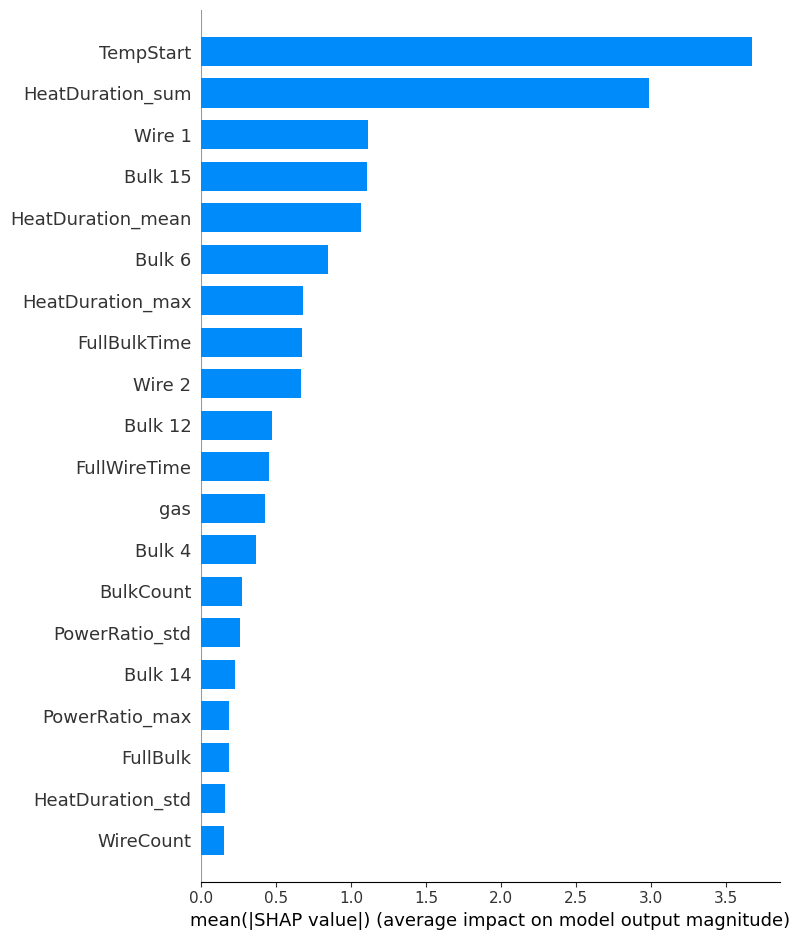

In [245]:
# Выведем график важности признаков

plt.figure(figsize=(8, 6))
shap.summary_plot(shap_values, X_test, plot_type="bar", show=False)
plt.tight_layout()
plt.show()

- TempStart - Наиболее важный фактор. Логично: чем выше температура на старте, тем выше будет и итоговая температура
- HeatDuration_sum - Вторая по значимости переменная. Чем дольше идёт нагрев, тем выше температура
- Bulk 15, Wire 1 - Сыпучие материалы скорее всего влияют на химический состав и изменение температуры
- HeatDuration_mean - Чем дольше идёт нагрев, тем выше температура
- Bulk 6 -  Вероятно, добавки, влияющая на температуру
- HeatDuration_mean - Чем дольше идёт нагрев, тем выше температура также
- FullBulkTime - Полное время подачи сыпучих материалов, видимо чем дольше подаются материалы тем выше температура
- Bulk 12, Wire 2 - Сыпучие  и проволочные материалы скорее всего влияют на химический состав и изменение температуры
- FullWireTime - Полное время подачи проволочных материалов, видимо чем дольше подаются материалы тем выше температура

Остальные признаки оказывают незначительное влияние на целевую переменную

Модель опирается на 2 основных признака: температуру старта и длительность нагрева.

### Зависимость входного и целевого признака

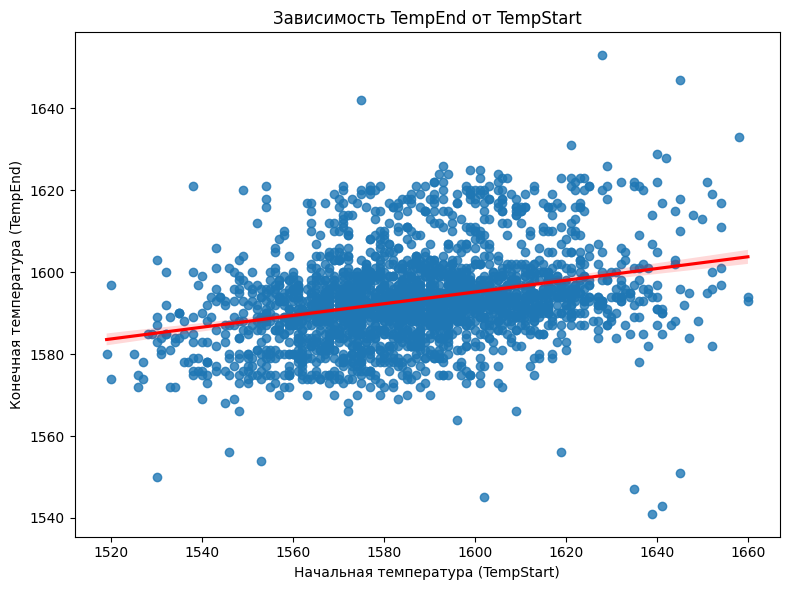

In [246]:
# Зависимость конечной температуры от начальной температуры

plt.figure(figsize=(8, 6))
sns.regplot(data=merged_clean, x='TempStart', y='TempEnd', line_kws={'color':'red'})
plt.title('Зависимость TempEnd от TempStart')
plt.xlabel('Начальная температура (TempStart)')
plt.ylabel('Конечная температура (TempEnd)')
plt.tight_layout()
plt.show()

При росте начальной температуры конечная тоже немного повышается. Также видим на графике несколько точек ниже и выше основной массы. И видим где у нас температура начала плавки = температуре конце плавки.

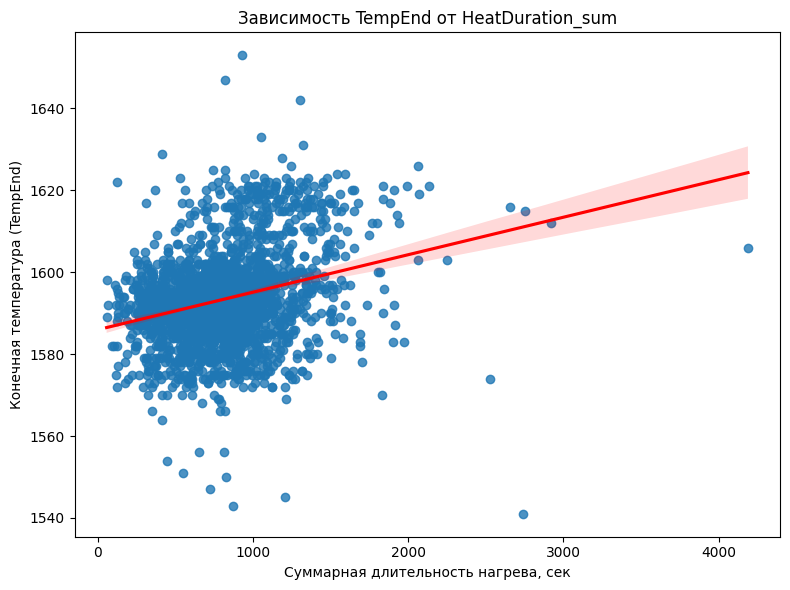

In [247]:
# Зависимость конечной температуры от длительности нагрева

plt.figure(figsize=(8, 6))
sns.regplot(data=merged_clean, x='HeatDuration_sum', y='TempEnd', line_kws={'color':'red'})
plt.title('Зависимость TempEnd от HeatDuration_sum')
plt.xlabel('Суммарная длительность нагрева, сек')
plt.ylabel('Конечная температура (TempEnd)')
plt.tight_layout()
plt.show()

При увеличении общего времени нагрева температура в среднем растёт

### Вывод

- Провели оценку качества модели на тестовой выборке и получили MAE = 5.769, что соответствует требованиям задачи.
- Сравнение с дамми-моделью показало, что разработанная модель демонстрирует существенно лучшие результаты.
- Построен график важности признаков - наибольшее влияние на целевую переменную оказывают начальная температура и суммарная длительность нагрева.
- Также визуализированы зависимости конечной температуры от начальной температуры и от суммарного времени нагрева. На графиках наблюдается ожидаемая положительная корреляция между этими параметрами.

## Шаг 5. Общий вывод

Напишем общие выводы, предложим способы для дальнейшего улучшения модели и дадим бизнес-рекомендации заказчику.

Процесс подготовки данных:
- исследовали распределения признаков, нашли и убрали выбросы и аномалии
- очистили пропуски, исправили ошибочные значения, добавили несколько производных признаков, отражающих длительность и интенсивность этапов нагрева
- провели базовый анализ корреляций и отобрали наиболее важные признаки
- разделили данные на обучающую и тестовую выборки

Процесс обучения модели:

- протестировали несколько алгоритмов (дерево решений, случайный лес, градиентный бустинг, LightGBM, CatBoost и MLP)

Лучше всех показал себя CatBoost - после настройки параметров ('depth': 6, 'learning_rate': 0.03, 'n_estimators': 600) он достиг MAE = 5.769 на тестовых данных.
Это заметно лучше, чем результат дамми модели, так что модель действительно учится, а не угадывает случайно.

Анализ важности признаков показал, что главную роль играют:

- начальная температура (TempStart)
- суммарная длительность нагрева (HeatDuration_sum)

На графиках зависимостей между этими параметрами и конечной температурой (TempEnd) видно ожидаемое поведение: чем выше температура на старте и чем дольше нагрев - тем выше итоговое значение.

Как можно улучшить модель:
- Поработать еще с выбросами как видно на графике зависимостей от конечной температуры они все еще остались
- Попробывать придумать еще какие-нибудь признаки
- Попробывать ансамблевые методы

Что можно рекомендовать заказчику:

- Использовать модель в режиме онлайн-прогноза - при вводе текущих параметров плавки можно заранее оценить ожидаемую температуру и коректировать режим нагрева

- Контролировать качество данных - внедрить мониторинг выбросов и ошибок измерений, чтобы повысить надёжность входных данных для модели

- Добавить больше параметров для мониторинга - например хим состав сыпучих материалов и проволоки